In [1]:
import numpy as np
import math
import pandas as pd
import tqdm
from scipy.stats import chi2, t
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta, Variable, exp
from biogeme import results as res
from IPython.display import display, Markdown, Latex
from biogeme.models import loglogit
from biogeme import biogeme
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from biogeme.models import piecewise_formula
from sklearn.model_selection import train_test_split

In [2]:
def likelihood_ratio_test(model_initial, model_next):
    LL_logit = model_initial.data.logLike
    LL_nested_existing = model_next.data.logLike
    LR = -2 * (LL_logit - LL_nested_existing)
    print(f'Statistic for the LR test: {LR:.3g}')

    dof = model_next.data.nparam - model_initial.data.nparam
    print(f'Degrees of freedom: {dof}')

    print(f'Threshold for the test: {chi2.isf(0.05, dof):.3g}')

    lr_test_existing = model_next.likelihood_ratio_test(model_initial, significance_level=0.05)
    print(f'{lr_test_existing.statistic=:.3g}')
    print(f'{lr_test_existing.threshold=:.3g}')
    print(lr_test_existing.message)

In [3]:
file_path = '../data_CSV/final_array.csv'
df = pd.read_csv(file_path)

/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_9052/482401865.py:2: DtypeWarning: Columns (8,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [4]:
df['unit_price']= df['price_driver']/df['distance_BBC']
df['airport_distance'] = df['airport_distance']/1000
df['trainstation_distance'] = df['trainstation_distance']/1000
df['electric_distance'] = df['electric_distance']/1000
df['bicycle_parking_distance'] = df['bicycle_parking_distance']/1000
df['tram_stop_distance'] = df['tram_stop_distance']/1000
df['subway_entrance_distance'] = df['subway_entrance_distance']/1000
df['bus_stop_distance'] = df['bus_stop_distance']/1000
df['bicycle_rental_distance'] = df['bicycle_rental_distance']/1000
df['fuel_distance'] = df['fuel_distance']/1000
df['dens_pop'] = df['dens_pop']/100  # de habitants par km2 a habitants par hectare 

print(df['bus_stop_distance'])

0         0.084061
1         0.163721
2         0.007305
3         0.038377
4         0.054396
            ...   
169278    0.033107
169279    0.131402
169280    0.084061
169281    0.029789
169282    0.079733
Name: bus_stop_distance, Length: 169283, dtype: float64


In [5]:
def time_to_minutes1(time_str):
    time_obj = datetime.strptime(time_str, '%H:%M:%S')  # Parse the string to a datetime object
    return time_obj.hour * 60 + time_obj.minute  # Convert to minutes

def time_to_minutes2(time_obj):
    return time_obj.hour * 60 + time_obj.minute  # Convert to minutes

In [6]:

# Filter out rows where `seats_booked` is not valid (negative values)
df = df[df['seats_booked'] >= 0]

# Ensure seats_booked is an integer
df['seats_booked'] = df['seats_booked'].astype(int)

# Create a list to store rows for the new DataFrame
result_rows = []

for _, row in df.iterrows():
    seats = row['seats_booked']
    row_data = row.to_dict()  # Convert the row to a dictionary
    if seats == 0:
        # Add the row with binary_seats = 0
        row_data['binary_seats'] = 0
        result_rows.append(row_data)
    elif seats >= 1:
        # Add the row with binary_seats = 1
        row_data['binary_seats'] = 1
        result_rows.append(row_data)

# Convert the list of rows to a DataFrame
result = pd.DataFrame(result_rows)


In [7]:
# Convert time strings to seconds since midnight
# Convert time strings to time objects
result['departure_time'] = result['departure_time'].apply(lambda x: x.split()[1])
result['departure_time'] = result['departure_time'].apply(lambda x: datetime.strptime(x, "%H:%M:%S").time())

# Define custom function for time categorization
def categorize_time(time_value):
    if time_value < datetime.strptime("04:00:00", "%H:%M:%S").time():
        return "Night"
    elif time_value < datetime.strptime("07:30:00", "%H:%M:%S").time():
        return "Morning_Normal"
    elif time_value < datetime.strptime("09:30:00", "%H:%M:%S").time():
        return "Morning_Pick"
    elif time_value < datetime.strptime("16:30:00", "%H:%M:%S").time():
        return "Mid_day"
    elif time_value < datetime.strptime("19:30:00", "%H:%M:%S").time():
        return "Evening_Pick"
    else:
        return "Evening_Normal"

# Apply the function to create the time_category column
result['time_category'] = result['departure_time'].apply(categorize_time)

# Perform one-hot encoding (binary columns for each category)
result = pd.get_dummies(result, columns=['time_category'], prefix='time')

# Ensure that the columns are binary (1 or 0)
result = result.astype({"time_Night": "int", "time_Morning_Normal": "int", "time_Morning_Pick": "int", "time_Mid_day": "int", "time_Evening_Pick": "int", "time_Evening_Normal": "int"})

In [8]:
from sklearn.cluster import KMeans

# Reshape car KMeans attend une matrice 2D
X = df[['dens_pop']].values.reshape(-1, 1)  
kmeans = KMeans(n_clusters=5, random_state=42).fit(X)

# Ajouter les catégories de densité issues du clustering
df['pop_density_cat'] = kmeans.labels_

# Affichage des intervalles pour chaque catégorie
intervals = []
for cluster in sorted(df['pop_density_cat'].unique()):
    cluster_values = df[df['pop_density_cat'] == cluster]['dens_pop']
    min_value, max_value = cluster_values.min(), cluster_values.max()
    intervals.append((cluster, min_value, max_value))

# Affichage des intervalles
for cluster, min_value, max_value in intervals:
    print(f"Catégorie {cluster}: [{min_value:.2f} - {max_value:.2f}]")
    


Catégorie 0: [0.17 - 62.99]
Catégorie 1: [223.78 - 270.42]
Catégorie 2: [280.28 - 388.51]
Catégorie 3: [63.56 - 129.22]
Catégorie 4: [136.47 - 213.32]


In [9]:
# Define custom function for time categorization
def categorize_denspop(denspop_value):
    if denspop_value < (intervals[0][2]+intervals[3][1])/2: #80:
        return "dens_a"
    elif denspop_value < (intervals[3][2]+intervals[4][1])/2: #160:
        return "dens_b"
    elif denspop_value < (intervals[4][2]+intervals[1][1])/2: #240:
        return "dens_c"
    elif denspop_value < (intervals[1][2]+intervals[2][1])/2: #320:
        return "dens_d"
    else:
        return "dens_e"

# Apply the function to create the time_category column
result['denspop_category'] = result['dens_pop'].apply(categorize_denspop)

# Perform one-hot encoding (binary columns for each category)
result = pd.get_dummies(result, columns=['denspop_category'], prefix='pop')

# Ensure that the columns are binary (1 or 0)
result = result.astype({"pop_dens_a": "int", "pop_dens_b": "int","pop_dens_c": "int","pop_dens_d": "int","pop_dens_e": "int"})
print("pop_dens_a:", result['pop_dens_a'].sum())
print("pop_dens_b:", result['pop_dens_b'].sum())
print("pop_dens_c:", result['pop_dens_c'].sum())
print("pop_dens_d:", result['pop_dens_d'].sum())
print("pop_dens_e:", result['pop_dens_e'].sum())

pop_dens_a: 50597
pop_dens_b: 39258
pop_dens_c: 24421
pop_dens_d: 33699
pop_dens_e: 21307


In [10]:
result = result.drop(columns=['arrival'])
result = result.drop(columns=['departure'])
result = result.drop(columns=['route'])
result = result.drop(columns=['departure_date_num'])
result = result.drop(columns=['announce_published_date'])
result = result.drop(columns=['departure_time'])
result = result.drop(columns=['car_mark'])
result = result.drop(columns=['car_model'])
result = result.drop(columns=['departure_date'])
result = result.drop(columns=['trip_description'])
result = result.drop(columns=['announce_views'])
result = result.drop(columns=['comment_average_note'])
result = result.drop(columns=['geometry'])
result = result.drop(columns=['driver_age'])
result = result.drop(columns=['driving_quality'])
result = result.drop(columns=['experience'])
result = result.drop(columns=['member_since_month'])
result = result.drop(columns=['member_since_year'])
result = result.drop(columns=['published_ads'])
result = result.drop(columns=['departure_strike'])
result = result.drop(columns=['commission'])
df_cleaned = result.dropna()
database = db.Database("lpmc09", df_cleaned)

In [11]:
#Declaration of the variables
#DensityPop = Variable('dens_pop')
Departure = Variable('Minutes')
Safety = Variable('norm_weighted_sum')
FuelStation1 = Variable('fuel_distance')
FuelStation2 = Variable('fuel_density')
BikeRent1 = Variable('bicycle_rental_distance')
BikeRent2 = Variable('bicycle_rental_density')
BusStop1 = Variable('bus_stop_distance')
BusStop2 = Variable('bus_stop_density')
SubwayEntr1 = Variable('subway_entrance_distance')
SubwayEntr2 = Variable('subway_entrance_density')
TramStop1 = Variable('tram_stop_distance')
TramStop2 = Variable('tram_stop_density')
BikePark1 = Variable('bicycle_parking_distance')
BikePark2 = Variable('bicycle_parking_density')
ElecPark1 = Variable('electric_distance')
ElecPark2 = Variable('electric_density')
TrainStation1 = Variable('trainstation_distance')
TrainStation2 = Variable('trainstation_density')
Airport1 = Variable('airport_distance')
Airport2 = Variable('airport_density')
CarpoolPark1 = Variable('parkCarpooling_distance')
CarpoolPark2 = Variable('parkCarpooling_density')
PplusR1 = Variable('parkRelais_distance')
PplusR2 = Variable('parkRelais_density')
Distance = Variable('distance_BBC')
departure_group_2 = Variable('time_Morning_Normal')
departure_group_3 = Variable('time_Morning_Pick')
departure_group_4 = Variable('time_Mid_day')
departure_group_5 = Variable('time_Evening_Pick')
departure_group_6 = Variable('time_Evening_Normal')
DensPop = Variable('dens_pop')
DensPop_group_2 = Variable('pop_dens_b')
DensPop_group_3 = Variable('pop_dens_c')
DensPop_group_4 = Variable('pop_dens_d')
DensPop_group_5 = Variable('pop_dens_e')
Centre = Variable('Centre')
Banlieue = Variable('Banlieue')
Price = Variable('unit_price')

#thresholds = [None, 500, 1500, 5000, 10000, 20000, 30000, None]
thresholds = [None, 5000, None]
formulaDensPop = piecewise_formula(variable=DensPop, thresholds=thresholds)
thresholds=[None,450,570,None]#thresholds = [
  ##  None,
  #  time_to_minutes2(datetime.strptime("04:00:00", "%H:%M:%S").time()),
  #  time_to_minutes2(datetime.strptime("07:30:00", "%H:%M:%S").time()),
  #  time_to_minutes2(datetime.strptime("09:30:00", "%H:%M:%S").time()),
  #  time_to_minutes2(datetime.strptime("16:30:00", "%H:%M:%S").time()),
  #  time_to_minutes2(datetime.strptime("19:30:00", "%H:%M:%S").time()),
   # None
#]
formulaTime = piecewise_formula(variable=Departure, thresholds=thresholds)

In [12]:
ChosenAlternative = Variable('binary_seats') #try with the duplicate version and try without

In [13]:
#Definition of the parameters

#beta_densitypop = Beta('beta_densitypop',0,None,None,0)
beta_safety = Beta('beta_safety',0,None,None,0)
beta_fueldist = Beta('beta_fueldist',0,None,None,0)
beta_fueldens = Beta('beta_fueldens',0,None,None,0)
beta_bikerentdist = Beta('beta_bikerentdist',0,None,None,0)
beta_bikerentdens = Beta('beta_bikerentdens',0,None,None,0)
beta_busstopdist = Beta('beta_busstopdist',0,None,None,0)
beta_busstopdens = Beta('beta_busstopdens',0,None,None,0)
beta_subentrdist = Beta('beta_subentrdist',0,None,None,0)
beta_subentrdens = Beta('beta_subentrdens',0,None,None,0)
beta_tramstopdist = Beta('beta_tramstopdist',0,None,None,0)
beta_tramstopdens = Beta('beta_tramstopdens',0,None,None,0)
beta_bikeparkdist = Beta('beta_bikeparkdist',0,None,None,0)
beta_bikeparkdens = Beta('beta_bikeparkdens',0,None,None,0)
beta_elecparkdist = Beta('beta_elecparkdist',0,None,None,0)
beta_elecparkdens = Beta('beta_elecparkdens',0,None,None,0)
beta_traindist = Beta('beta_traindist',0,None,None,0)
beta_traindens = Beta('beta_traindens',0,None,None,0)
beta_airportdist = Beta('beta_airportdist',0,None,None,0)
beta_airportdens = Beta('beta_airportdens',0,None,None,0)
beta_carpoolparkdist = Beta('beta_carpoolparkdist',0,None,None,0)
beta_carpoolparkdens = Beta('beta_carpoolparkdens',0,None,None,0)
beta_parkRelaisdist = Beta('beta_parkRelaisdist',0,None,None,0)
beta_parkRelaisdens = Beta('beta_parkRelaisdens',0,None,None,0)
beta_distance = Beta('beta_distance',0,None,None,0) 
beta_departure_2 = Beta('beta_departure_2', 0, None, None, 0) #piecewise (voir mmb)
beta_departure_3 = Beta('beta_departure_3', 0, None, None, 0)
beta_departure_4 = Beta('beta_departure_4', 0, None, None, 0)
beta_departure_5 = Beta('beta_departure_5', 0, None, None, 0)
beta_departure_6 = Beta('beta_departure_6', 0, None, None, 0)
beta_densPop_2 = Beta('beta_densPop_2', 0, None, None, 0)
beta_densPop_3 = Beta('beta_densPop_3', 0, None, None, 0)
beta_densPop_4 = Beta('beta_densPop_4', 0, None, None, 0)
beta_densPop_5 = Beta('beta_densPop_5', 0, None, None, 0)
beta_price = Beta('beta_price',0,None,None,0)
beta_centre= Beta('beta_centre',0,None,None,0)
beta_banlieue = Beta('beta_banlieue',0,None,None,0)
ASC_1 = Beta('ASC_1', 0, None, None, 0)

In [14]:
N = df_cleaned.shape[0]
J = 2

init_log_likelihood = N*math.log(1/J)
print(f"Initial Log-Likelihood: {init_log_likelihood}")

Initial Log-Likelihood: -117337.34101954866


In [15]:
# reussir a calculer la distance

In [15]:
from scipy.stats import chi2

def likelihood_ratio_test(model_1, model_0):
    """
    Effectue un test du rapport de vraisemblance (LRT) entre deux modèles.
    
    Args:
    model_1 (bio.BIOGEME): Le modèle complet.
    model_0 (bio.BIOGEME): Le modèle nul (ou modèle restreint).
    
    Returns:
    dict: Résultats du test LRT, y compris la statistique du test et la p-value.
    """
    # Estimation du modèle complet
    result_1 = model_1.estimate()
    log_likelihood_1 = result_1.data.logLike
    
    # Estimation du modèle nul
    result_0 = model_0.estimate()
    log_likelihood_0 = result_0.data.logLike
    
    # Calcul de la statistique du test LRT
    lrt_statistic = -2 * (log_likelihood_0 - log_likelihood_1)
    
    # Degrés de liberté (différence du nombre de paramètres entre les modèles)
    df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
    
    # Calcul de la p-value
    p_value = chi2.sf(lrt_statistic, df)
    
    return {
        'lrt_statistic': lrt_statistic,
        'degrees_of_freedom': df,
        'p_value': p_value
    }



In [16]:
# Step 1: Assign a unique GROUP ID to each (departure, arrival, departure_date_num)
#df_cleaned['GROUP'] = df_cleaned.groupby(['departure', 'arrival', 'departure_date_num']).ngroup()  # Ensure IDs start from 1

# Step 2: Count how many alternatives each GROUP has
#group_sizes = df_cleaned.groupby('GROUP').size().to_dict()  # {GROUP_ID: number of alternatives}

# Étape 3: Définir la taille max
#max_alternatives = max(group_sizes.values()) 

# Étape 4: Générer les colonnes avail_1 ... avail_max_alternatives
#avail_columns = [f"avail_{i}" for i in range(max_alternatives)]
#availability_matrix = np.zeros((len(df), max_alternatives), dtype=int)  # Matrice remplie de 0
 
# Étape 5: Remplir les colonnes
#for idx, row in df.iterrows():
    #group_id = row['GROUP']
    #size = group_sizes[group_id]  # Nombre d'alternatives pour ce groupe
    #availability_matrix[idx, :size] = 1  # Met 1 dans les premières colonnes correspondant à la taille du groupe

# Étape 6: Ajouter au dataframe
#df_availability = pd.DataFrame(availability_matrix, columns=avail_columns)
#df_cleaned = pd.concat([df_cleaned, df_availability], axis=1)

# Afficher le résultat
#print(df_cleaned['avail_100'])


In [17]:
# Séparer les données en deux ensembles (80 % - 20 %)
train_data, test_data = train_test_split(df_cleaned, test_size=0.2, random_state=None)
# Define the Biogeme database for the training data
database_train = db.Database('train', train_data)

print(len(train_data))

135425


In [19]:
V_seats_00 = (
    ASC_1 + beta_price*Price +
    beta_elecparkdist*ElecPark1 +
    beta_elecparkdens*ElecPark2 +
    beta_bikeparkdist*BikePark1 +
    beta_bikeparkdens*BikePark2 +
    beta_tramstopdist*TramStop1 +
    beta_tramstopdens*TramStop2 +
    beta_subentrdist*SubwayEntr1 +
    beta_subentrdens*SubwayEntr2 +
    beta_busstopdist*BusStop1 +
    beta_busstopdens*BusStop2 +
    beta_bikerentdist*BikeRent1 +
    beta_bikerentdens*BikeRent2 +
    beta_fueldist*FuelStation1 +
    beta_fueldens*FuelStation2 +
    beta_densPop_2*DensPop_group_2 +
    beta_densPop_3*DensPop_group_3 +
    beta_densPop_4*DensPop_group_4 +
    beta_densPop_5*DensPop_group_5 +
    beta_departure_2*departure_group_2 +
    beta_departure_3*departure_group_3 +
    beta_departure_4*departure_group_4 +
    beta_departure_5*departure_group_5 +
    beta_departure_6*departure_group_6 +
    beta_banlieue*Banlieue +
    beta_centre*Centre 
)

# Model specification
V = {1: V_seats_00, 0: 0}  # Utility functions: 1 for seats, 0 is the baseline
av = {1: 1, 0: 1}  # Availability: both alternatives are always available

# Log-likelihood function
logprob = loglogit(V, None, ChosenAlternative)

# Create the Biogeme object
model_00 = bio.BIOGEME(database_train, logprob)

# Model name
model_00.modelName = 'binary_logit_seats'

results = {}

results['binary_logit_seats'] = model_00.estimate()
model_estimation_00 = results['binary_logit_seats']
print(results['binary_logit_seats'].printGeneralStatistics())
#likelihood_ratio_test(model_estimation_01 ,model_estimation_6 )
results['binary_logit_seats'].getEstimatedParameters()

Number of estimated parameters:	27
Sample size:	135425
Excluded observations:	0
Init log likelihood:	-92234.82
Final log likelihood:	-92182.85
Likelihood ratio test for the init. model:	103.9351
Rho-square for the init. model:	0.000563
Rho-square-bar for the init. model:	0.000271
Akaike Information Criterion:	184419.7
Bayesian Information Criterion:	184684.7
Final gradient norm:	1.9590E-01
Nbr of threads:	4



/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2492421572.py:47: DeprecationWarning: printGeneralStatistics is deprecated; use print_general_statistics instead.
  print(results['binary_logit_seats'].printGeneralStatistics())
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2492421572.py:49: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  results['binary_logit_seats'].getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_1,0.023079,0.118751,0.194347,8.459042e-01
beta_banlieue,-0.170369,0.081951,-2.078923,3.762443e-02
beta_bikeparkdens,0.000133,0.000146,0.911867,3.618388e-01
beta_bikeparkdist,-0.026753,0.020064,-1.333373,1.824094e-01
beta_bikerentdens,-0.003042,0.001673,-1.818817,6.893934e-02
beta_bikerentdist,-0.019255,0.003112,-6.187874,6.098118e-10
beta_busstopdens,0.003787,0.000537,7.054017,1.738165e-12
beta_busstopdist,-0.388314,0.084444,-4.598490,4.255647e-06
beta_centre,0.049320,0.084136,0.586191,5.577469e-01
beta_densPop_2,0.142984,0.020588,6.944965,3.785638e-12


In [20]:
# Modèle nul (par exemple, un modèle sans variables explicatives)
V_null = {1: ASC_1, 0: 0}  # Utilité sans aucune variable explicative
logprob_null = loglogit(V_null, None, ChosenAlternative)

# Création du modèle nul
model_null = bio.BIOGEME(database_train, logprob_null)

# Application du test LRT
lrt_results = likelihood_ratio_test(model_00, model_null)

print("LRT Statistique:", lrt_results['lrt_statistic'])
print("Degrés de liberté:", lrt_results['degrees_of_freedom'])
print("P-value:", lrt_results['p_value'])

You have not defined a name for the model. The output .py are named from the model name. The default is [biogemeModelDefaultName]


LRT Statistique: 2850.489095901634
Degrés de liberté: 26
P-value: 0.0


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]


In [21]:
# Récupération des paramètres estimés
beta_estimates = results['binary_logit_seats'].get_beta_values()

V_seats_00_test = (
    beta_estimates['ASC_1'] + beta_estimates['beta_price'] * test_data['unit_price'] +
    beta_estimates['beta_elecparkdist'] * test_data['electric_distance'] +
    beta_estimates['beta_elecparkdens'] * test_data['electric_density'] +
    beta_estimates['beta_bikeparkdist'] * test_data['bicycle_parking_distance'] +
    beta_estimates['beta_bikeparkdens'] * test_data['bicycle_parking_density'] +
    beta_estimates['beta_tramstopdist'] * test_data['tram_stop_distance'] +
    beta_estimates['beta_tramstopdens'] * test_data['tram_stop_density'] +
    beta_estimates['beta_subentrdist'] * test_data['subway_entrance_distance'] +
    beta_estimates['beta_subentrdens'] * test_data['subway_entrance_density'] +
    beta_estimates['beta_busstopdist'] * test_data['bus_stop_distance'] +
    beta_estimates['beta_busstopdens'] * test_data['bus_stop_density'] +
    beta_estimates['beta_bikerentdist'] * test_data['bicycle_rental_distance'] +
    beta_estimates['beta_bikerentdens'] * test_data['bicycle_rental_density'] +
    beta_estimates['beta_fueldist'] * test_data['fuel_distance'] +
    beta_estimates['beta_fueldens'] * test_data['fuel_density'] +
    beta_estimates['beta_densPop_2'] * test_data['pop_dens_b'] +
    beta_estimates['beta_densPop_3'] * test_data['pop_dens_c'] +
    beta_estimates['beta_densPop_4'] * test_data['pop_dens_d'] +
    beta_estimates['beta_densPop_5'] * test_data['pop_dens_e'] +
    beta_estimates['beta_departure_2'] * test_data['time_Morning_Normal'] +
    beta_estimates['beta_departure_3'] * test_data['time_Morning_Pick'] +
    beta_estimates['beta_departure_4'] * test_data['time_Mid_day'] +
    beta_estimates['beta_departure_5'] * test_data['time_Evening_Pick'] +
    beta_estimates['beta_departure_6'] * test_data['time_Evening_Normal'] +
    beta_estimates['beta_banlieue'] * test_data['Banlieue'] +
    beta_estimates['beta_centre'] * test_data['Centre']
    
)

# Utilité pour l'alternative 0 (baseline) est toujours 0
V_0_test = np.zeros_like(V_seats_00_test)

# Calcul des probabilités pour chaque observation dans les données de test
probabilities_test = np.exp(V_seats_00_test) / (np.exp(V_seats_00_test) + np.exp(V_0_test))

# Affichage des probabilités simulées
print(probabilities_test)

# Calcul des prédictions : Si la probabilité pour l'alternative 1 est plus grande que 0.5, on prédit l'alternative 1, sinon on prédit l'alternative 0
predictions = (probabilities_test > 0.5).astype(int)

# Comparer avec l'alternative réellement choisie (assumant qu'elle soit dans la colonne 'ChosenAlternative')
correct_predictions = (predictions == test_data['binary_seats']).sum()

# Calcul du pourcentage de prédictions correctes
accuracy = (correct_predictions / len(test_data)) * 100

# Affichage du pourcentage de prédictions correctes
print(f"Pourcentage de prédictions correctes : {accuracy:.2f}%")


128447    0.453882
26353     0.486684
112757    0.447675
130118    0.546622
134439    0.481472
            ...   
26692     0.437111
69355     0.501483
12323     0.419652
85596     0.520011
167543    0.299060
Length: 33857, dtype: float64
Pourcentage de prédictions correctes : 55.84%


In [18]:
# Liste des variables utilisées dans le modèle
model_variables = [
    'unit_price','electric_distance','electric_density','bicycle_parking_distance', 'bicycle_parking_density', 
    'bicycle_rental_distance','bicycle_rental_density','tram_stop_distance','tram_stop_density','subway_entrance_distance', 'subway_entrance_density',
    'bus_stop_distance','bus_stop_density','fuel_distance', 'fuel_density', 'Centre', 'Banlieue','time_Night','time_Morning_Normal','time_Morning_Pick','time_Mid_day',
    'time_Evening_Pick','time_Evening_Normal','pop_dens_a','pop_dens_b','pop_dens_c','pop_dens_d','pop_dens_e'
]

# Extraction des variables spécifiques
data_model = database_train.data[model_variables]

# Calcul de la matrice de corrélation
correlation_matrix = data_model.corr()

# Affichage du tableau des corrélations
# Affichage des 14 premières colonnes et lignes
print(correlation_matrix.iloc[:, 14:])


                          fuel_density    Centre  Banlieue  time_Night  \
unit_price                    0.034481  0.046271 -0.044106    0.022258   
electric_distance            -0.173767 -0.288028  0.269710   -0.004350   
electric_density              0.257184  0.624383 -0.613081    0.012614   
bicycle_parking_distance     -0.113939 -0.162703  0.099709    0.004530   
bicycle_parking_density       0.076620  0.700488 -0.685419    0.026042   
bicycle_rental_distance      -0.250463 -0.356879  0.294350   -0.004536   
bicycle_rental_density        0.260550  0.791079 -0.776746    0.033562   
tram_stop_distance           -0.249484 -0.223343  0.162334    0.001449   
tram_stop_density             0.427687  0.412415 -0.401657    0.011697   
subway_entrance_distance     -0.274922 -0.388887  0.331254   -0.009540   
subway_entrance_density       0.064151  0.692853 -0.681124    0.034249   
bus_stop_distance            -0.028636 -0.098254  0.063577    0.005283   
bus_stop_density              0.113156

In [23]:
# Affichage des 14 dernières colonnes et lignes
print(correlation_matrix.iloc[:, -14:])

                          fuel_density    Centre  Banlieue  time_Night  \
unit_price                    0.035731  0.046275 -0.044576    0.020246   
electric_distance            -0.173785 -0.290675  0.272583   -0.003112   
electric_density              0.257088  0.621779 -0.610421    0.010804   
bicycle_parking_distance     -0.113787 -0.161982  0.100017    0.006806   
bicycle_parking_density       0.077228  0.699540 -0.684470    0.025095   
bicycle_rental_distance      -0.249578 -0.355505  0.293051   -0.004524   
bicycle_rental_density        0.261304  0.790703 -0.776383    0.032193   
tram_stop_distance           -0.248515 -0.224775  0.164322    0.001917   
tram_stop_density             0.426662  0.413054 -0.402298    0.012405   
subway_entrance_distance     -0.274762 -0.389767  0.332465   -0.008155   
subway_entrance_density       0.065603  0.692552 -0.680843    0.033848   
bus_stop_distance            -0.029684 -0.098472  0.065073    0.004958   
bus_stop_density              0.113036

In [24]:
V_seats_01 = (
    ASC_1 + beta_price*Price +
    beta_elecparkdist*ElecPark1 +
    beta_elecparkdens*ElecPark2 +
    beta_bikeparkdist*BikePark1 +
    beta_bikeparkdens*BikePark2 +
    beta_tramstopdist*TramStop1 +
    beta_tramstopdens*TramStop2 +
    beta_subentrdist*SubwayEntr1 +
    beta_subentrdens*SubwayEntr2 +
    beta_busstopdist*BusStop1 +
    beta_busstopdens*BusStop2 +
    beta_bikerentdist*BikeRent1 +
    beta_bikerentdens*BikeRent2 +
    beta_fueldist*FuelStation1 +
    beta_fueldens*FuelStation2 +
    beta_densPop_2*DensPop_group_2 +
    beta_densPop_3*DensPop_group_3 +
    beta_densPop_4*DensPop_group_4 +
    beta_densPop_5*DensPop_group_5 +
    beta_departure_2*departure_group_2 +
    beta_departure_3*departure_group_3 +
    beta_departure_4*departure_group_4 +
    beta_departure_5*departure_group_5 +
    beta_departure_6*departure_group_6 +
    beta_banlieue*Banlieue 
)

# Model specification
V = {1: V_seats_01, 0: 0}  # Utility functions: 1 for seats, 0 is the baseline
av = {1: 1, 0: 1}  # Availability: both alternatives are always available

# Log-likelihood function
logprob = loglogit(V, None, ChosenAlternative)

# Create the Biogeme object
model_01 = bio.BIOGEME(database_train, logprob)

# Model name
model_01.modelName = 'binary_logit_seats'

results = {}

results['binary_logit_seats'] = model_01.estimate()
model_estimation_01 = results['binary_logit_seats']
print(results['binary_logit_seats'].printGeneralStatistics())
likelihood_ratio_test(model_01 ,model_00 )
results['binary_logit_seats'].getEstimatedParameters()

/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/1299451802.py:46: DeprecationWarning: printGeneralStatistics is deprecated; use print_general_statistics instead.
  print(results['binary_logit_seats'].printGeneralStatistics())


Number of estimated parameters:	26
Sample size:	135425
Excluded observations:	0
Init log likelihood:	-92203.19
Final log likelihood:	-92183.03
Likelihood ratio test for the init. model:	40.33341
Rho-square for the init. model:	0.000219
Rho-square-bar for the init. model:	-6.33e-05
Akaike Information Criterion:	184418.1
Bayesian Information Criterion:	184673.3
Final gradient norm:	7.6532E-01
Nbr of threads:	4



/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/1299451802.py:48: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  results['binary_logit_seats'].getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_1,0.069386,0.085384,0.812639,4.164252e-01
beta_banlieue,-0.215716,0.025815,-8.356102,0.000000e+00
beta_bikeparkdens,0.000136,0.000146,0.929492,3.526342e-01
beta_bikeparkdist,-0.028519,0.019796,-1.440629,1.496896e-01
beta_bikerentdens,-0.002971,0.001669,-1.780838,7.493889e-02
beta_bikerentdist,-0.019491,0.003089,-6.309816,2.793674e-10
beta_busstopdens,0.003766,0.000535,7.034380,2.001510e-12
beta_busstopdist,-0.390360,0.084202,-4.635976,3.552571e-06
beta_densPop_2,0.142610,0.020580,6.929699,4.217293e-12
beta_densPop_3,0.102644,0.025770,3.983100,6.802202e-05


In [25]:
# Modèle nul (par exemple, un modèle sans variables explicatives)
V_null = {1: ASC_1, 0: 0}  # Utilité sans aucune variable explicative
logprob_null = loglogit(V_null, None, ChosenAlternative)

# Création du modèle nul
model_null = bio.BIOGEME(database_train, logprob_null)

# Application du test LRT
lrt_results = likelihood_ratio_test(model_01, model_null)

print("LRT Statistique:", lrt_results['lrt_statistic'])
print("Degrés de liberté:", lrt_results['degrees_of_freedom'])
print("P-value:", lrt_results['p_value'])

You have not defined a name for the model. The output .py are named from the model name. The default is [biogemeModelDefaultName]


LRT Statistique: 2850.134185210918
Degrés de liberté: 25
P-value: 0.0


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]


In [26]:
# Récupération des paramètres estimés
beta_estimates = results['binary_logit_seats'].get_beta_values()

V_seats_01_test = (
    beta_estimates['ASC_1'] + beta_estimates['beta_price'] * test_data['unit_price'] +
    beta_estimates['beta_elecparkdist'] * test_data['electric_distance'] +
    beta_estimates['beta_elecparkdens'] * test_data['electric_density'] +
    beta_estimates['beta_bikeparkdist'] * test_data['bicycle_parking_distance'] +
    beta_estimates['beta_bikeparkdens'] * test_data['bicycle_parking_density'] +
    beta_estimates['beta_tramstopdist'] * test_data['tram_stop_distance'] +
    beta_estimates['beta_tramstopdens'] * test_data['tram_stop_density'] +
    beta_estimates['beta_subentrdist'] * test_data['subway_entrance_distance'] +
    beta_estimates['beta_subentrdens'] * test_data['subway_entrance_density'] +
    beta_estimates['beta_busstopdist'] * test_data['bus_stop_distance'] +
    beta_estimates['beta_busstopdens'] * test_data['bus_stop_density'] +
    beta_estimates['beta_bikerentdist'] * test_data['bicycle_rental_distance'] +
    beta_estimates['beta_bikerentdens'] * test_data['bicycle_rental_density'] +
    beta_estimates['beta_fueldist'] * test_data['fuel_distance'] +
    beta_estimates['beta_fueldens'] * test_data['fuel_density'] +
    beta_estimates['beta_densPop_2'] * test_data['pop_dens_b'] +
    beta_estimates['beta_densPop_3'] * test_data['pop_dens_c'] +
    beta_estimates['beta_densPop_4'] * test_data['pop_dens_d'] +
    beta_estimates['beta_densPop_5'] * test_data['pop_dens_e'] +
    beta_estimates['beta_departure_2'] * test_data['time_Morning_Normal'] +
    beta_estimates['beta_departure_3'] * test_data['time_Morning_Pick'] +
    beta_estimates['beta_departure_4'] * test_data['time_Mid_day'] +
    beta_estimates['beta_departure_5'] * test_data['time_Evening_Pick'] +
    beta_estimates['beta_departure_6'] * test_data['time_Evening_Normal'] +
    beta_estimates['beta_banlieue'] * test_data['Banlieue'] 
    
)

# Utilité pour l'alternative 0 (baseline) est toujours 0
V_01_test = np.zeros_like(V_seats_01_test)

# Calcul des probabilités pour chaque observation dans les données de test
probabilities_test = np.exp(V_seats_01_test) / (np.exp(V_seats_01_test) + np.exp(V_01_test))

# Affichage des probabilités simulées
print(probabilities_test)

# Calcul des prédictions : Si la probabilité pour l'alternative 1 est plus grande que 0.5, on prédit l'alternative 1, sinon on prédit l'alternative 0
predictions = (probabilities_test > 0.5).astype(int)
print(predictions)

# Comparer avec l'alternative réellement choisie (assumant qu'elle soit dans la colonne 'ChosenAlternative')
correct_predictions = (predictions == test_data['binary_seats']).sum()

# Calcul du pourcentage de prédictions correctes
accuracy = (correct_predictions / len(test_data)) * 100

# Affichage du pourcentage de prédictions correctes
print(f"Pourcentage de prédictions correctes : {accuracy:.2f}%")


128447    0.453692
26353     0.486619
112757    0.448288
130118    0.546343
134439    0.481336
            ...   
26692     0.437539
69355     0.501408
12323     0.419193
85596     0.519856
167543    0.297612
Length: 33857, dtype: float64
128447    0
26353     0
112757    0
130118    1
134439    0
         ..
26692     0
69355     1
12323     0
85596     1
167543    0
Length: 33857, dtype: int64
Pourcentage de prédictions correctes : 55.84%


In [27]:
V_seats_02 = (
    ASC_1 + beta_price*Price +
    beta_elecparkdist*ElecPark1 +
    beta_elecparkdens*ElecPark2 +
    beta_bikeparkdist*BikePark1 +
    beta_bikeparkdens*BikePark2 +
    beta_tramstopdist*TramStop1 +
    beta_tramstopdens*TramStop2 +
    beta_subentrdist*SubwayEntr1 +
    beta_busstopdist*BusStop1 +
    beta_busstopdens*BusStop2 +
    beta_bikerentdist*BikeRent1 +
    beta_bikerentdens*BikeRent2 +
    beta_fueldist*FuelStation1 +
    beta_fueldens*FuelStation2 +
    beta_densPop_2*DensPop_group_2 +
    beta_densPop_3*DensPop_group_3 +
    beta_densPop_4*DensPop_group_4 +
    beta_densPop_5*DensPop_group_5 +
    beta_departure_2*departure_group_2 +
    beta_departure_3*departure_group_3 +
    beta_departure_4*departure_group_4 +
    beta_departure_5*departure_group_5 +
    beta_departure_6*departure_group_6 +
    beta_banlieue*Banlieue 
)

# Model specification
V = {1: V_seats_02, 0: 0}  # Utility functions: 1 for seats, 0 is the baseline
av = {1: 1, 0: 1}  # Availability: both alternatives are always available

# Log-likelihood function
logprob = loglogit(V, None, ChosenAlternative)

# Create the Biogeme object
model_02 = bio.BIOGEME(database_train, logprob)

# Model name
model_02.modelName = 'binary_logit_seats'

results = {}

results['binary_logit_seats'] = model_02.estimate()
model_estimation_02 = results['binary_logit_seats']
print(results['binary_logit_seats'].printGeneralStatistics())
likelihood_ratio_test(model_02 ,model_01 )
results['binary_logit_seats'].getEstimatedParameters()

/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/75969267.py:45: DeprecationWarning: printGeneralStatistics is deprecated; use print_general_statistics instead.
  print(results['binary_logit_seats'].printGeneralStatistics())


Number of estimated parameters:	25
Sample size:	135425
Excluded observations:	0
Init log likelihood:	-92186.33
Final log likelihood:	-92183.31
Likelihood ratio test for the init. model:	6.037289
Rho-square for the init. model:	3.27e-05
Rho-square-bar for the init. model:	-0.000238
Akaike Information Criterion:	184416.6
Bayesian Information Criterion:	184662
Final gradient norm:	2.2823E-01
Nbr of threads:	4



/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/75969267.py:47: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  results['binary_logit_seats'].getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_1,0.070468,0.085373,0.825410,4.091391e-01
beta_banlieue,-0.212405,0.025393,-8.364529,0.000000e+00
beta_bikeparkdens,0.000110,0.000142,0.771889,4.401800e-01
beta_bikeparkdist,-0.028760,0.019830,-1.450344,1.469627e-01
beta_bikerentdens,-0.003460,0.001539,-2.248888,2.451963e-02
beta_bikerentdist,-0.019707,0.003078,-6.402519,1.528340e-10
beta_busstopdens,0.003713,0.000530,7.000595,2.548850e-12
beta_busstopdist,-0.391433,0.084251,-4.646024,3.383942e-06
beta_densPop_2,0.141728,0.020545,6.898295,5.263123e-12
beta_densPop_3,0.102007,0.025752,3.961132,7.459541e-05


In [28]:
# Modèle nul (par exemple, un modèle sans variables explicatives)
V_null = {1: ASC_1, 0: 0}  # Utilité sans aucune variable explicative
logprob_null = loglogit(V_null, None, ChosenAlternative)

# Création du modèle nul
model_null = bio.BIOGEME(database_train, logprob_null)

# Application du test LRT
lrt_results = likelihood_ratio_test(model_02, model_null)

print("LRT Statistique:", lrt_results['lrt_statistic'])
print("Degrés de liberté:", lrt_results['degrees_of_freedom'])
print("P-value:", lrt_results['p_value'])

You have not defined a name for the model. The output .py are named from the model name. The default is [biogemeModelDefaultName]


LRT Statistique: 2849.565292726882
Degrés de liberté: 24
P-value: 0.0


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]


In [29]:
# Récupération des paramètres estimés
beta_estimates = results['binary_logit_seats'].get_beta_values()

V_seats_02_test = (
    beta_estimates['ASC_1'] + beta_estimates['beta_price'] * test_data['unit_price'] +
    beta_estimates['beta_elecparkdist'] * test_data['electric_distance'] +
    beta_estimates['beta_elecparkdens'] * test_data['electric_density'] +
    beta_estimates['beta_bikeparkdist'] * test_data['bicycle_parking_distance'] +
    beta_estimates['beta_bikeparkdens'] * test_data['bicycle_parking_density'] +
    beta_estimates['beta_tramstopdist'] * test_data['tram_stop_distance'] +
    beta_estimates['beta_tramstopdens'] * test_data['tram_stop_density'] +
    beta_estimates['beta_subentrdist'] * test_data['subway_entrance_distance'] +
    beta_estimates['beta_busstopdist'] * test_data['bus_stop_distance'] +
    beta_estimates['beta_busstopdens'] * test_data['bus_stop_density'] +
    beta_estimates['beta_bikerentdist'] * test_data['bicycle_rental_distance'] +
    beta_estimates['beta_bikerentdens'] * test_data['bicycle_rental_density'] +
    beta_estimates['beta_fueldist'] * test_data['fuel_distance'] +
    beta_estimates['beta_fueldens'] * test_data['fuel_density'] +
    beta_estimates['beta_densPop_2'] * test_data['pop_dens_b'] +
    beta_estimates['beta_densPop_3'] * test_data['pop_dens_c'] +
    beta_estimates['beta_densPop_4'] * test_data['pop_dens_d'] +
    beta_estimates['beta_densPop_5'] * test_data['pop_dens_e'] +
    beta_estimates['beta_departure_2'] * test_data['time_Morning_Normal'] +
    beta_estimates['beta_departure_3'] * test_data['time_Morning_Pick'] +
    beta_estimates['beta_departure_4'] * test_data['time_Mid_day'] +
    beta_estimates['beta_departure_5'] * test_data['time_Evening_Pick'] +
    beta_estimates['beta_departure_6'] * test_data['time_Evening_Normal'] +
    beta_estimates['beta_banlieue'] * test_data['Banlieue'] 
    
)

# Utilité pour l'alternative 0 (baseline) est toujours 0
V_02_test = np.zeros_like(V_seats_02_test)

# Calcul des probabilités pour chaque observation dans les données de test
probabilities_test = np.exp(V_seats_02_test) / (np.exp(V_seats_02_test) + np.exp(V_02_test))

# Affichage des probabilités simulées
print(probabilities_test)

# Calcul des prédictions : Si la probabilité pour l'alternative 1 est plus grande que 0.5, on prédit l'alternative 1, sinon on prédit l'alternative 0
predictions = (probabilities_test > 0.5).astype(int)
print(predictions)

# Comparer avec l'alternative réellement choisie (assumant qu'elle soit dans la colonne 'ChosenAlternative')
correct_predictions = (predictions == test_data['binary_seats']).sum()

# Calcul du pourcentage de prédictions correctes
accuracy = (correct_predictions / len(test_data)) * 100

# Affichage du pourcentage de prédictions correctes
print(f"Pourcentage de prédictions correctes : {accuracy:.2f}%")


128447    0.454471
26353     0.487059
112757    0.448786
130118    0.544217
134439    0.481172
            ...   
26692     0.437134
69355     0.501853
12323     0.420376
85596     0.518465
167543    0.297873
Length: 33857, dtype: float64
128447    0
26353     0
112757    0
130118    1
134439    0
         ..
26692     0
69355     1
12323     0
85596     1
167543    0
Length: 33857, dtype: int64
Pourcentage de prédictions correctes : 55.81%


In [30]:
V_seats_03 = (
    ASC_1 + beta_price*Price +
    beta_elecparkdens*ElecPark2 +
    beta_bikeparkdist*BikePark1 +
    beta_bikeparkdens*BikePark2 +
    beta_tramstopdist*TramStop1 +
    beta_tramstopdens*TramStop2 +
    beta_subentrdist*SubwayEntr1 +
    beta_busstopdist*BusStop1 +
    beta_busstopdens*BusStop2 +
    beta_bikerentdist*BikeRent1 +
    beta_bikerentdens*BikeRent2 +
    beta_fueldist*FuelStation1 +
    beta_fueldens*FuelStation2 +
    beta_densPop_2*DensPop_group_2 +
    beta_densPop_3*DensPop_group_3 +
    beta_densPop_4*DensPop_group_4 +
    beta_densPop_5*DensPop_group_5 +
    beta_departure_2*departure_group_2 +
    beta_departure_3*departure_group_3 +
    beta_departure_4*departure_group_4 +
    beta_departure_5*departure_group_5 +
    beta_departure_6*departure_group_6 +
    beta_banlieue*Banlieue 
)

# Model specification
V = {1: V_seats_03, 0: 0}  # Utility functions: 1 for seats, 0 is the baseline
av = {1: 1, 0: 1}  # Availability: both alternatives are always available

# Log-likelihood function
logprob = loglogit(V, None, ChosenAlternative)

# Create the Biogeme object
model_03 = bio.BIOGEME(database_train, logprob)

# Model name
model_03.modelName = 'binary_logit_seats'

results = {}

results['binary_logit_seats'] = model_03.estimate()
model_estimation_03 = results['binary_logit_seats']
print(results['binary_logit_seats'].printGeneralStatistics())
likelihood_ratio_test(model_03 ,model_02 )
results['binary_logit_seats'].getEstimatedParameters()

/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/3917157894.py:44: DeprecationWarning: printGeneralStatistics is deprecated; use print_general_statistics instead.
  print(results['binary_logit_seats'].printGeneralStatistics())


Number of estimated parameters:	24
Sample size:	135425
Excluded observations:	0
Init log likelihood:	-92186.8
Final log likelihood:	-92184.71
Likelihood ratio test for the init. model:	4.179277
Rho-square for the init. model:	2.27e-05
Rho-square-bar for the init. model:	-0.000238
Akaike Information Criterion:	184417.4
Bayesian Information Criterion:	184653
Final gradient norm:	1.1853E-01
Nbr of threads:	4



/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/3917157894.py:46: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  results['binary_logit_seats'].getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_1,0.061462,0.085181,0.721542,4.705761e-01
beta_banlieue,-0.213649,0.025373,-8.420307,0.000000e+00
beta_bikeparkdens,0.000133,0.000141,0.940868,3.467726e-01
beta_bikeparkdist,-0.029764,0.019874,-1.497662,1.342211e-01
beta_bikerentdens,-0.003869,0.001519,-2.546982,1.086589e-02
beta_bikerentdist,-0.020628,0.003020,-6.829537,8.518963e-12
beta_busstopdens,0.003692,0.000530,6.965378,3.275158e-12
beta_busstopdist,-0.395308,0.084092,-4.700909,2.590054e-06
beta_densPop_2,0.139968,0.020515,6.822637,8.938406e-12
beta_densPop_3,0.100135,0.025728,3.892119,9.937250e-05


In [31]:
# Modèle nul (par exemple, un modèle sans variables explicatives)
V_null = {1: ASC_1, 0: 0}  # Utilité sans aucune variable explicative
logprob_null = loglogit(V_null, None, ChosenAlternative)

# Création du modèle nul
model_null = bio.BIOGEME(database_train, logprob_null)

# Application du test LRT
lrt_results = likelihood_ratio_test(model_03, model_null)

print("LRT Statistique:", lrt_results['lrt_statistic'])
print("Degrés de liberté:", lrt_results['degrees_of_freedom'])
print("P-value:", lrt_results['p_value'])

You have not defined a name for the model. The output .py are named from the model name. The default is [biogemeModelDefaultName]


LRT Statistique: 2846.7737976925855
Degrés de liberté: 23
P-value: 0.0


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]


In [32]:
# Récupération des paramètres estimés
beta_estimates = results['binary_logit_seats'].get_beta_values()

V_seats_03_test = (
    beta_estimates['ASC_1'] + beta_estimates['beta_price'] * test_data['unit_price'] +
    beta_estimates['beta_elecparkdens'] * test_data['electric_density'] +
    beta_estimates['beta_bikeparkdist'] * test_data['bicycle_parking_distance'] +
    beta_estimates['beta_bikeparkdens'] * test_data['bicycle_parking_density'] +
    beta_estimates['beta_tramstopdist'] * test_data['tram_stop_distance'] +
    beta_estimates['beta_tramstopdens'] * test_data['tram_stop_density'] +
    beta_estimates['beta_subentrdist'] * test_data['subway_entrance_distance'] +
    beta_estimates['beta_busstopdist'] * test_data['bus_stop_distance'] +
    beta_estimates['beta_busstopdens'] * test_data['bus_stop_density'] +
    beta_estimates['beta_bikerentdist'] * test_data['bicycle_rental_distance'] +
    beta_estimates['beta_bikerentdens'] * test_data['bicycle_rental_density'] +
    beta_estimates['beta_fueldist'] * test_data['fuel_distance'] +
    beta_estimates['beta_fueldens'] * test_data['fuel_density'] +
    beta_estimates['beta_densPop_2'] * test_data['pop_dens_b'] +
    beta_estimates['beta_densPop_3'] * test_data['pop_dens_c'] +
    beta_estimates['beta_densPop_4'] * test_data['pop_dens_d'] +
    beta_estimates['beta_densPop_5'] * test_data['pop_dens_e'] +
    beta_estimates['beta_departure_2'] * test_data['time_Morning_Normal'] +
    beta_estimates['beta_departure_3'] * test_data['time_Morning_Pick'] +
    beta_estimates['beta_departure_4'] * test_data['time_Mid_day'] +
    beta_estimates['beta_departure_5'] * test_data['time_Evening_Pick'] +
    beta_estimates['beta_departure_6'] * test_data['time_Evening_Normal'] +
    beta_estimates['beta_banlieue'] * test_data['Banlieue'] 
    
)

# Utilité pour l'alternative 0 (baseline) est toujours 0
V_03_test = np.zeros_like(V_seats_03_test)

# Calcul des probabilités pour chaque observation dans les données de test
probabilities_test = np.exp(V_seats_03_test) / (np.exp(V_seats_03_test) + np.exp(V_03_test))

# Affichage des probabilités simulées
print(probabilities_test)

# Calcul des prédictions : Si la probabilité pour l'alternative 1 est plus grande que 0.5, on prédit l'alternative 1, sinon on prédit l'alternative 0
predictions = (probabilities_test > 0.5).astype(int)
print(predictions)

# Comparer avec l'alternative réellement choisie (assumant qu'elle soit dans la colonne 'ChosenAlternative')
correct_predictions = (predictions == test_data['binary_seats']).sum()

# Calcul du pourcentage de prédictions correctes
accuracy = (correct_predictions / len(test_data)) * 100

# Affichage du pourcentage de prédictions correctes
print(f"Pourcentage de prédictions correctes : {accuracy:.2f}%")


128447    0.452348
26353     0.487116
112757    0.448358
130118    0.543796
134439    0.488607
            ...   
26692     0.435920
69355     0.501904
12323     0.420444
85596     0.517337
167543    0.293622
Length: 33857, dtype: float64
128447    0
26353     0
112757    0
130118    1
134439    0
         ..
26692     0
69355     1
12323     0
85596     1
167543    0
Length: 33857, dtype: int64
Pourcentage de prédictions correctes : 55.81%


In [33]:
V_seats_04 = (
    ASC_1 + beta_price*Price +
    beta_elecparkdens*ElecPark2 +
    beta_bikeparkdens*BikePark2 +
    beta_tramstopdist*TramStop1 +
    beta_tramstopdens*TramStop2 +
    beta_subentrdist*SubwayEntr1 +
    beta_busstopdist*BusStop1 +
    beta_busstopdens*BusStop2 +
    beta_bikerentdist*BikeRent1 +
    beta_bikerentdens*BikeRent2 +
    beta_fueldist*FuelStation1 +
    beta_fueldens*FuelStation2 +
    beta_densPop_2*DensPop_group_2 +
    beta_densPop_3*DensPop_group_3 +
    beta_densPop_4*DensPop_group_4 +
    beta_densPop_5*DensPop_group_5 +
    beta_departure_2*departure_group_2 +
    beta_departure_3*departure_group_3 +
    beta_departure_4*departure_group_4 +
    beta_departure_5*departure_group_5 +
    beta_departure_6*departure_group_6 +
    beta_banlieue*Banlieue 
)

# Model specification
V = {1: V_seats_04, 0: 0}  # Utility functions: 1 for seats, 0 is the baseline
av = {1: 1, 0: 1}  # Availability: both alternatives are always available

# Log-likelihood function
logprob = loglogit(V, None, ChosenAlternative)

# Create the Biogeme object
model_04 = bio.BIOGEME(database_train, logprob)

# Model name
model_04.modelName = 'binary_logit_seats'

results = {}

results['binary_logit_seats'] = model_04.estimate()
model_estimation_04 = results['binary_logit_seats']
print(results['binary_logit_seats'].printGeneralStatistics())
likelihood_ratio_test(model_04 ,model_03 )
results['binary_logit_seats'].getEstimatedParameters()

/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2039633753.py:43: DeprecationWarning: printGeneralStatistics is deprecated; use print_general_statistics instead.
  print(results['binary_logit_seats'].printGeneralStatistics())


Number of estimated parameters:	23
Sample size:	135425
Excluded observations:	0
Init log likelihood:	-92187.17
Final log likelihood:	-92186.21
Likelihood ratio test for the init. model:	1.908819
Rho-square for the init. model:	1.04e-05
Rho-square-bar for the init. model:	-0.000239
Akaike Information Criterion:	184418.4
Bayesian Information Criterion:	184644.2
Final gradient norm:	3.8079E-01
Nbr of threads:	4



/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2039633753.py:45: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  results['binary_logit_seats'].getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_1,0.057037,0.085097,0.670259,5.026926e-01
beta_banlieue,-0.211194,0.025318,-8.341690,0.000000e+00
beta_bikeparkdens,0.000142,0.000141,1.006467,3.141910e-01
beta_bikerentdens,-0.003940,0.001517,-2.596654,9.413667e-03
beta_bikerentdist,-0.021965,0.002936,-7.482062,7.327472e-14
beta_busstopdens,0.003757,0.000528,7.117452,1.099343e-12
beta_busstopdist,-0.418495,0.082548,-5.069698,3.984476e-07
beta_densPop_2,0.140258,0.020507,6.839656,7.938317e-12
beta_densPop_3,0.098788,0.025721,3.840810,1.226292e-04
beta_densPop_4,0.156200,0.027673,5.644574,1.655906e-08


In [34]:
# Modèle nul (par exemple, un modèle sans variables explicatives)
V_null = {1: ASC_1, 0: 0}  # Utilité sans aucune variable explicative
logprob_null = loglogit(V_null, None, ChosenAlternative)

# Création du modèle nul
model_null = bio.BIOGEME(database_train, logprob_null)

# Application du test LRT
lrt_results = likelihood_ratio_test(model_04, model_null)

print("LRT Statistique:", lrt_results['lrt_statistic'])
print("Degrés de liberté:", lrt_results['degrees_of_freedom'])
print("P-value:", lrt_results['p_value'])

You have not defined a name for the model. The output .py are named from the model name. The default is [biogemeModelDefaultName]


LRT Statistique: 2843.7612716922013
Degrés de liberté: 22
P-value: 0.0


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]


In [35]:
# Récupération des paramètres estimés
beta_estimates = results['binary_logit_seats'].get_beta_values()

V_seats_04_test = (
    beta_estimates['ASC_1'] + beta_estimates['beta_price'] * test_data['unit_price'] +
    beta_estimates['beta_elecparkdens'] * test_data['electric_density'] +
    beta_estimates['beta_bikeparkdens'] * test_data['bicycle_parking_density'] +
    beta_estimates['beta_tramstopdist'] * test_data['tram_stop_distance'] +
    beta_estimates['beta_tramstopdens'] * test_data['tram_stop_density'] +
    beta_estimates['beta_subentrdist'] * test_data['subway_entrance_distance'] +
    beta_estimates['beta_busstopdist'] * test_data['bus_stop_distance'] +
    beta_estimates['beta_busstopdens'] * test_data['bus_stop_density'] +
    beta_estimates['beta_bikerentdist'] * test_data['bicycle_rental_distance'] +
    beta_estimates['beta_bikerentdens'] * test_data['bicycle_rental_density'] +
    beta_estimates['beta_fueldist'] * test_data['fuel_distance'] +
    beta_estimates['beta_fueldens'] * test_data['fuel_density'] +
    beta_estimates['beta_densPop_2'] * test_data['pop_dens_b'] +
    beta_estimates['beta_densPop_3'] * test_data['pop_dens_c'] +
    beta_estimates['beta_densPop_4'] * test_data['pop_dens_d'] +
    beta_estimates['beta_densPop_5'] * test_data['pop_dens_e'] +
    beta_estimates['beta_departure_2'] * test_data['time_Morning_Normal'] +
    beta_estimates['beta_departure_3'] * test_data['time_Morning_Pick'] +
    beta_estimates['beta_departure_4'] * test_data['time_Mid_day'] +
    beta_estimates['beta_departure_5'] * test_data['time_Evening_Pick'] +
    beta_estimates['beta_departure_6'] * test_data['time_Evening_Normal'] +
    beta_estimates['beta_banlieue'] * test_data['Banlieue'] 
    
)

# Utilité pour l'alternative 0 (baseline) est toujours 0
V_04_test = np.zeros_like(V_seats_04_test)

# Calcul des probabilités pour chaque observation dans les données de test
probabilities_test = np.exp(V_seats_04_test) / (np.exp(V_seats_04_test) + np.exp(V_04_test))

# Affichage des probabilités simulées
print(probabilities_test)

# Calcul des prédictions : Si la probabilité pour l'alternative 1 est plus grande que 0.5, on prédit l'alternative 1, sinon on prédit l'alternative 0
predictions = (probabilities_test > 0.5).astype(int)
print(predictions)

# Comparer avec l'alternative réellement choisie (assumant qu'elle soit dans la colonne 'ChosenAlternative')
correct_predictions = (predictions == test_data['binary_seats']).sum()

# Calcul du pourcentage de prédictions correctes
accuracy = (correct_predictions / len(test_data)) * 100

# Affichage du pourcentage de prédictions correctes
print(f"Pourcentage de prédictions correctes : {accuracy:.2f}%")


128447    0.451898
26353     0.487167
112757    0.448829
130118    0.543697
134439    0.487052
            ...   
26692     0.435862
69355     0.501973
12323     0.420785
85596     0.517301
167543    0.298860
Length: 33857, dtype: float64
128447    0
26353     0
112757    0
130118    1
134439    0
         ..
26692     0
69355     1
12323     0
85596     1
167543    0
Length: 33857, dtype: int64
Pourcentage de prédictions correctes : 55.79%


In [36]:
V_seats_05 = (
    ASC_1 + beta_price*Price +
    beta_bikeparkdens*BikePark2 +
    beta_tramstopdist*TramStop1 +
    beta_tramstopdens*TramStop2 +
    beta_subentrdist*SubwayEntr1 +
    beta_busstopdist*BusStop1 +
    beta_busstopdens*BusStop2 +
    beta_bikerentdist*BikeRent1 +
    beta_bikerentdens*BikeRent2 +
    beta_fueldist*FuelStation1 +
    beta_fueldens*FuelStation2 +
    beta_densPop_2*DensPop_group_2 +
    beta_densPop_3*DensPop_group_3 +
    beta_densPop_4*DensPop_group_4 +
    beta_densPop_5*DensPop_group_5 +
    beta_departure_2*departure_group_2 +
    beta_departure_3*departure_group_3 +
    beta_departure_4*departure_group_4 +
    beta_departure_5*departure_group_5 +
    beta_departure_6*departure_group_6 +
    beta_banlieue*Banlieue 
)

# Model specification
V = {1: V_seats_05, 0: 0}  # Utility functions: 1 for seats, 0 is the baseline
av = {1: 1, 0: 1}  # Availability: both alternatives are always available

# Log-likelihood function
logprob = loglogit(V, None, ChosenAlternative)

# Create the Biogeme object
model_05 = bio.BIOGEME(database_train, logprob)

# Model name
model_05.modelName = 'binary_logit_seats'

results = {}

results['binary_logit_seats'] = model_05.estimate()
model_estimation_05 = results['binary_logit_seats']
print(results['binary_logit_seats'].printGeneralStatistics())
likelihood_ratio_test(model_05 ,model_04 )
results['binary_logit_seats'].getEstimatedParameters()

/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2853582511.py:42: DeprecationWarning: printGeneralStatistics is deprecated; use print_general_statistics instead.
  print(results['binary_logit_seats'].printGeneralStatistics())


Number of estimated parameters:	22
Sample size:	135425
Excluded observations:	0
Init log likelihood:	-92199.59
Final log likelihood:	-92188.08
Likelihood ratio test for the init. model:	23.01643
Rho-square for the init. model:	0.000125
Rho-square-bar for the init. model:	-0.000114
Akaike Information Criterion:	184420.2
Bayesian Information Criterion:	184636.1
Final gradient norm:	3.0664E-01
Nbr of threads:	4



/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2853582511.py:44: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  results['binary_logit_seats'].getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_1,0.054425,0.085085,0.639661,5.223931e-01
beta_banlieue,-0.208100,0.025269,-8.235320,2.220446e-16
beta_bikeparkdens,0.000134,0.000141,0.946624,3.438303e-01
beta_bikerentdens,-0.004549,0.001484,-3.066070,2.168926e-03
beta_bikerentdist,-0.021235,0.002910,-7.296758,2.948752e-13
beta_busstopdens,0.003552,0.000516,6.876174,6.148193e-12
beta_busstopdist,-0.423390,0.082649,-5.122734,3.011370e-07
beta_densPop_2,0.143902,0.020431,7.043459,1.875167e-12
beta_densPop_3,0.100854,0.025705,3.923494,8.727385e-05
beta_densPop_4,0.152843,0.027600,5.537793,3.063073e-08


In [37]:
# Modèle nul (par exemple, un modèle sans variables explicatives)
V_null = {1: ASC_1, 0: 0}  # Utilité sans aucune variable explicative
logprob_null = loglogit(V_null, None, ChosenAlternative)

# Création du modèle nul
model_null = bio.BIOGEME(database_train, logprob_null)

# Application du test LRT
lrt_results = likelihood_ratio_test(model_05, model_null)

print("LRT Statistique:", lrt_results['lrt_statistic'])
print("Degrés de liberté:", lrt_results['degrees_of_freedom'])
print("P-value:", lrt_results['p_value'])

You have not defined a name for the model. The output .py are named from the model name. The default is [biogemeModelDefaultName]


LRT Statistique: 2840.027197928197
Degrés de liberté: 21
P-value: 0.0


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]


In [38]:
# Récupération des paramètres estimés
beta_estimates = results['binary_logit_seats'].get_beta_values()

V_seats_05_test = (
    beta_estimates['ASC_1'] + beta_estimates['beta_price'] * test_data['unit_price'] +
    beta_estimates['beta_bikeparkdens'] * test_data['bicycle_parking_density'] +
    beta_estimates['beta_tramstopdist'] * test_data['tram_stop_distance'] +
    beta_estimates['beta_tramstopdens'] * test_data['tram_stop_density'] +
    beta_estimates['beta_subentrdist'] * test_data['subway_entrance_distance'] +
    beta_estimates['beta_busstopdist'] * test_data['bus_stop_distance'] +
    beta_estimates['beta_busstopdens'] * test_data['bus_stop_density'] +
    beta_estimates['beta_bikerentdist'] * test_data['bicycle_rental_distance'] +
    beta_estimates['beta_bikerentdens'] * test_data['bicycle_rental_density'] +
    beta_estimates['beta_fueldist'] * test_data['fuel_distance'] +
    beta_estimates['beta_fueldens'] * test_data['fuel_density'] +
    beta_estimates['beta_densPop_2'] * test_data['pop_dens_b'] +
    beta_estimates['beta_densPop_3'] * test_data['pop_dens_c'] +
    beta_estimates['beta_densPop_4'] * test_data['pop_dens_d'] +
    beta_estimates['beta_densPop_5'] * test_data['pop_dens_e'] +
    beta_estimates['beta_departure_2'] * test_data['time_Morning_Normal'] +
    beta_estimates['beta_departure_3'] * test_data['time_Morning_Pick'] +
    beta_estimates['beta_departure_4'] * test_data['time_Mid_day'] +
    beta_estimates['beta_departure_5'] * test_data['time_Evening_Pick'] +
    beta_estimates['beta_departure_6'] * test_data['time_Evening_Normal'] +
    beta_estimates['beta_banlieue'] * test_data['Banlieue'] 
    
)

# Utilité pour l'alternative 0 (baseline) est toujours 0
V_05_test = np.zeros_like(V_seats_05_test)

# Calcul des probabilités pour chaque observation dans les données de test
probabilities_test = np.exp(V_seats_05_test) / (np.exp(V_seats_05_test) + np.exp(V_05_test))

# Affichage des probabilités simulées
print(probabilities_test)

# Calcul des prédictions : Si la probabilité pour l'alternative 1 est plus grande que 0.5, on prédit l'alternative 1, sinon on prédit l'alternative 0
predictions = (probabilities_test > 0.5).astype(int)
print(predictions)

# Comparer avec l'alternative réellement choisie (assumant qu'elle soit dans la colonne 'ChosenAlternative')
correct_predictions = (predictions == test_data['binary_seats']).sum()

# Calcul du pourcentage de prédictions correctes
accuracy = (correct_predictions / len(test_data)) * 100

# Affichage du pourcentage de prédictions correctes
print(f"Pourcentage de prédictions correctes : {accuracy:.2f}%")


128447    0.453238
26353     0.486484
112757    0.446696
130118    0.544196
134439    0.484489
            ...   
26692     0.433085
69355     0.501223
12323     0.421741
85596     0.519897
167543    0.303457
Length: 33857, dtype: float64
128447    0
26353     0
112757    0
130118    1
134439    0
         ..
26692     0
69355     1
12323     0
85596     1
167543    0
Length: 33857, dtype: int64
Pourcentage de prédictions correctes : 55.91%


In [39]:
V_seats_06 = (
    ASC_1 + beta_price*Price +
    beta_bikeparkdens*BikePark2 +
    beta_tramstopdist*TramStop1 +
    beta_tramstopdens*TramStop2 +
    beta_subentrdist*SubwayEntr1 +
    beta_busstopdist*BusStop1 +
    beta_busstopdens*BusStop2 +
    beta_bikerentdist*BikeRent1 +
    beta_bikerentdens*BikeRent2 +
    beta_fueldens*FuelStation2 +
    beta_densPop_2*DensPop_group_2 +
    beta_densPop_3*DensPop_group_3 +
    beta_densPop_4*DensPop_group_4 +
    beta_densPop_5*DensPop_group_5 +
    beta_departure_2*departure_group_2 +
    beta_departure_3*departure_group_3 +
    beta_departure_4*departure_group_4 +
    beta_departure_5*departure_group_5 +
    beta_departure_6*departure_group_6 +
    beta_banlieue*Banlieue 
)

# Model specification
V = {1: V_seats_06, 0: 0}  # Utility functions: 1 for seats, 0 is the baseline
av = {1: 1, 0: 1}  # Availability: both alternatives are always available

# Log-likelihood function
logprob = loglogit(V, None, ChosenAlternative)

# Create the Biogeme object
model_06 = bio.BIOGEME(database_train, logprob)

# Model name
model_06.modelName = 'binary_logit_seats'

results = {}

results['binary_logit_seats'] = model_06.estimate()
model_estimation_06 = results['binary_logit_seats']
print(results['binary_logit_seats'].printGeneralStatistics())
likelihood_ratio_test(model_06 ,model_05 )
results['binary_logit_seats'].getEstimatedParameters()

/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2333655320.py:41: DeprecationWarning: printGeneralStatistics is deprecated; use print_general_statistics instead.
  print(results['binary_logit_seats'].printGeneralStatistics())


Number of estimated parameters:	21
Sample size:	135425
Excluded observations:	0
Init log likelihood:	-92189.48
Final log likelihood:	-92188.42
Likelihood ratio test for the init. model:	2.126345
Rho-square for the init. model:	1.15e-05
Rho-square-bar for the init. model:	-0.000216
Akaike Information Criterion:	184418.8
Bayesian Information Criterion:	184625
Final gradient norm:	3.2969E-01
Nbr of threads:	4



/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2333655320.py:43: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  results['binary_logit_seats'].getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_1,0.063441,0.084401,0.751656,4.522582e-01
beta_banlieue,-0.209577,0.025217,-8.310842,0.000000e+00
beta_bikeparkdens,0.000131,0.000141,0.929168,3.528020e-01
beta_bikerentdens,-0.004578,0.001483,-3.086592,2.024655e-03
beta_bikerentdist,-0.021075,0.002902,-7.261091,3.839151e-13
beta_busstopdens,0.003539,0.000516,6.854215,7.170486e-12
beta_busstopdist,-0.420872,0.082655,-5.091889,3.545141e-07
beta_densPop_2,0.144148,0.020428,7.056419,1.708411e-12
beta_densPop_3,0.100893,0.025705,3.924969,8.674106e-05
beta_densPop_4,0.152196,0.027588,5.516700,3.454234e-08


In [40]:
# Modèle nul (par exemple, un modèle sans variables explicatives)
V_null = {1: ASC_1, 0: 0}  # Utilité sans aucune variable explicative
logprob_null = loglogit(V_null, None, ChosenAlternative)

# Création du modèle nul
model_null = bio.BIOGEME(database_train, logprob_null)

# Application du test LRT
lrt_results = likelihood_ratio_test(model_06, model_null)

print("LRT Statistique:", lrt_results['lrt_statistic'])
print("Degrés de liberté:", lrt_results['degrees_of_freedom'])
print("P-value:", lrt_results['p_value'])

You have not defined a name for the model. The output .py are named from the model name. The default is [biogemeModelDefaultName]


LRT Statistique: 2839.3504729192646
Degrés de liberté: 20
P-value: 0.0


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]


In [ ]:
# Récupération des paramètres estimés
beta_estimates = results['binary_logit_seats'].get_beta_values()

V_seats_06_test = (
    beta_estimates['ASC_1'] + beta_estimates['beta_price'] * test_data['unit_price'] +
    beta_estimates['beta_bikeparkdens'] * test_data['bicycle_parking_density'] +
    beta_estimates['beta_tramstopdist'] * test_data['tram_stop_distance'] +
    beta_estimates['beta_tramstopdens'] * test_data['tram_stop_density'] +
    beta_estimates['beta_subentrdist'] * test_data['subway_entrance_distance'] +
    beta_estimates['beta_busstopdist'] * test_data['bus_stop_distance'] +
    beta_estimates['beta_busstopdens'] * test_data['bus_stop_density'] +
    beta_estimates['beta_bikerentdist'] * test_data['bicycle_rental_distance'] +
    beta_estimates['beta_bikerentdens'] * test_data['bicycle_rental_density'] +
    beta_estimates['beta_fueldens'] * test_data['fuel_density'] +
    beta_estimates['beta_densPop_2'] * test_data['pop_dens_b'] +
    beta_estimates['beta_densPop_3'] * test_data['pop_dens_c'] +
    beta_estimates['beta_densPop_4'] * test_data['pop_dens_d'] +
    beta_estimates['beta_densPop_5'] * test_data['pop_dens_e'] +
    beta_estimates['beta_departure_2'] * test_data['time_Morning_Normal'] +
    beta_estimates['beta_departure_3'] * test_data['time_Morning_Pick'] +
    beta_estimates['beta_departure_4'] * test_data['time_Mid_day'] +
    beta_estimates['beta_departure_5'] * test_data['time_Evening_Pick'] +
    beta_estimates['beta_departure_6'] * test_data['time_Evening_Normal'] +
    beta_estimates['beta_banlieue'] * test_data['Banlieue'] 
    
)

# Utilité pour l'alternative 0 (baseline) est toujours 0
V_06_test = np.zeros_like(V_seats_06_test)

# Calcul des probabilités pour chaque observation dans les données de test
probabilities_test = np.exp(V_seats_06_test) / (np.exp(V_seats_06_test) + np.exp(V_06_test))

# Affichage des probabilités simulées
print(probabilities_test)

# Calcul des prédictions : Si la probabilité pour l'alternative 1 est plus grande que 0.5, on prédit l'alternative 1, sinon on prédit l'alternative 0
predictions = (probabilities_test > 0.5).astype(int)
print(predictions)

# Comparer avec l'alternative réellement choisie (assumant qu'elle soit dans la colonne 'ChosenAlternative')
correct_predictions = (predictions == test_data['binary_seats']).sum()

# Calcul du pourcentage de prédictions correctes
accuracy = (correct_predictions / len(test_data)) * 100

# Affichage du pourcentage de prédictions correctes
print(f"Pourcentage de prédictions correctes : {accuracy:.2f}%")


128447    0.452111
26353     0.486479
112757    0.447456
130118    0.544042
134439    0.485499
            ...   
26692     0.433331
69355     0.501218
12323     0.420930
85596     0.520303
167543    0.304520
Length: 33857, dtype: float64
128447    0
26353     0
112757    0
130118    1
134439    0
         ..
26692     0
69355     1
12323     0
85596     1
167543    0
Length: 33857, dtype: int64
Pourcentage de prédictions correctes : 55.89%


In [42]:
V_seats_07 = (
    ASC_1 + beta_price*Price +
    beta_bikeparkdens*BikePark2 +
    beta_tramstopdist*TramStop1 +
    beta_tramstopdens*TramStop2 +
    beta_subentrdist*SubwayEntr1 +
    beta_busstopdist*BusStop1 +
    beta_busstopdens*BusStop2 +
    beta_bikerentdist*BikeRent1 +
    beta_bikerentdens*BikeRent2 +
    beta_densPop_2*DensPop_group_2 +
    beta_densPop_3*DensPop_group_3 +
    beta_densPop_4*DensPop_group_4 +
    beta_densPop_5*DensPop_group_5 +
    beta_departure_2*departure_group_2 +
    beta_departure_3*departure_group_3 +
    beta_departure_4*departure_group_4 +
    beta_departure_5*departure_group_5 +
    beta_departure_6*departure_group_6 +
    beta_banlieue*Banlieue 
)

# Model specification
V = {1: V_seats_07, 0: 0}  # Utility functions: 1 for seats, 0 is the baseline
av = {1: 1, 0: 1}  # Availability: both alternatives are always available

# Log-likelihood function
logprob = loglogit(V, None, ChosenAlternative)

# Create the Biogeme object
model_07 = bio.BIOGEME(database_train, logprob)

# Model name
model_07.modelName = 'binary_logit_seats'

results = {}

results['binary_logit_seats'] = model_07.estimate()
model_estimation_07 = results['binary_logit_seats']
print(results['binary_logit_seats'].printGeneralStatistics())
likelihood_ratio_test(model_07 ,model_06 )
results['binary_logit_seats'].getEstimatedParameters()

/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/3947615975.py:40: DeprecationWarning: printGeneralStatistics is deprecated; use print_general_statistics instead.
  print(results['binary_logit_seats'].printGeneralStatistics())


Number of estimated parameters:	20
Sample size:	135425
Excluded observations:	0
Init log likelihood:	-92202.05
Final log likelihood:	-92193.37
Likelihood ratio test for the init. model:	17.35969
Rho-square for the init. model:	9.41e-05
Rho-square-bar for the init. model:	-0.000123
Akaike Information Criterion:	184426.7
Bayesian Information Criterion:	184623.1
Final gradient norm:	3.3385E-01
Nbr of threads:	4



/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/3947615975.py:42: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  results['binary_logit_seats'].getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_1,0.081911,0.084237,0.972387,3.308581e-01
beta_banlieue,-0.219143,0.025038,-8.752556,0.000000e+00
beta_bikeparkdens,0.000012,0.000136,0.087802,9.300343e-01
beta_bikerentdens,-0.003714,0.001457,-2.547919,1.083675e-02
beta_bikerentdist,-0.021794,0.002894,-7.531260,5.018208e-14
beta_busstopdens,0.003619,0.000515,7.020727,2.207123e-12
beta_busstopdist,-0.412821,0.082274,-5.017617,5.231648e-07
beta_densPop_2,0.147682,0.020396,7.240781,4.460876e-13
beta_densPop_3,0.102939,0.025702,4.005037,6.200783e-05
beta_densPop_4,0.161420,0.027420,5.886987,3.932990e-09


In [43]:
# Modèle nul (par exemple, un modèle sans variables explicatives)
V_null = {1: ASC_1, 0: 0}  # Utilité sans aucune variable explicative
logprob_null = loglogit(V_null, None, ChosenAlternative)

# Création du modèle nul
model_null = bio.BIOGEME(database_train, logprob_null)

# Application du test LRT
lrt_results = likelihood_ratio_test(model_07, model_null)

print("LRT Statistique:", lrt_results['lrt_statistic'])
print("Degrés de liberté:", lrt_results['degrees_of_freedom'])
print("P-value:", lrt_results['p_value'])

You have not defined a name for the model. The output .py are named from the model name. The default is [biogemeModelDefaultName]


LRT Statistique: 2829.4520424838993
Degrés de liberté: 19
P-value: 0.0


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]


In [44]:
# Récupération des paramètres estimés
beta_estimates = results['binary_logit_seats'].get_beta_values()

V_seats_07_test = (
    beta_estimates['ASC_1'] + beta_estimates['beta_price'] * test_data['unit_price'] +
    beta_estimates['beta_bikeparkdens'] * test_data['bicycle_parking_density'] +
    beta_estimates['beta_tramstopdist'] * test_data['tram_stop_distance'] +
    beta_estimates['beta_tramstopdens'] * test_data['tram_stop_density'] +
    beta_estimates['beta_subentrdist'] * test_data['subway_entrance_distance'] +
    beta_estimates['beta_busstopdist'] * test_data['bus_stop_distance'] +
    beta_estimates['beta_busstopdens'] * test_data['bus_stop_density'] +
    beta_estimates['beta_bikerentdist'] * test_data['bicycle_rental_distance'] +
    beta_estimates['beta_bikerentdens'] * test_data['bicycle_rental_density'] +
    beta_estimates['beta_densPop_2'] * test_data['pop_dens_b'] +
    beta_estimates['beta_densPop_3'] * test_data['pop_dens_c'] +
    beta_estimates['beta_densPop_4'] * test_data['pop_dens_d'] +
    beta_estimates['beta_densPop_5'] * test_data['pop_dens_e'] +
    beta_estimates['beta_departure_2'] * test_data['time_Morning_Normal'] +
    beta_estimates['beta_departure_3'] * test_data['time_Morning_Pick'] +
    beta_estimates['beta_departure_4'] * test_data['time_Mid_day'] +
    beta_estimates['beta_departure_5'] * test_data['time_Evening_Pick'] +
    beta_estimates['beta_departure_6'] * test_data['time_Evening_Normal'] +
    beta_estimates['beta_banlieue'] * test_data['Banlieue'] 
    
)

# Utilité pour l'alternative 0 (baseline) est toujours 0
V_07_test = np.zeros_like(V_seats_07_test)

# Calcul des probabilités pour chaque observation dans les données de test
probabilities_test = np.exp(V_seats_07_test) / (np.exp(V_seats_07_test) + np.exp(V_07_test))

# Affichage des probabilités simulées
print(probabilities_test)

# Calcul des prédictions : Si la probabilité pour l'alternative 1 est plus grande que 0.5, on prédit l'alternative 1, sinon on prédit l'alternative 0
predictions = (probabilities_test > 0.5).astype(int)
print(predictions)

# Comparer avec l'alternative réellement choisie (assumant qu'elle soit dans la colonne 'ChosenAlternative')
correct_predictions = (predictions == test_data['binary_seats']).sum()

# Calcul du pourcentage de prédictions correctes
accuracy = (correct_predictions / len(test_data)) * 100

# Affichage du pourcentage de prédictions correctes
print(f"Pourcentage de prédictions correctes : {accuracy:.2f}%")


128447    0.453666
26353     0.488334
112757    0.451579
130118    0.541919
134439    0.486821
            ...   
26692     0.434940
69355     0.502933
12323     0.418970
85596     0.524625
167543    0.305366
Length: 33857, dtype: float64
128447    0
26353     0
112757    0
130118    1
134439    0
         ..
26692     0
69355     1
12323     0
85596     1
167543    0
Length: 33857, dtype: int64
Pourcentage de prédictions correctes : 55.94%


In [45]:
V_seats_08 = (
    ASC_1 + beta_price*Price +
    beta_tramstopdist*TramStop1 +
    beta_tramstopdens*TramStop2 +
    beta_subentrdist*SubwayEntr1 +
    beta_busstopdist*BusStop1 +
    beta_busstopdens*BusStop2 +
    beta_bikerentdist*BikeRent1 +
    beta_bikerentdens*BikeRent2 +
    beta_densPop_2*DensPop_group_2 +
    beta_densPop_3*DensPop_group_3 +
    beta_densPop_4*DensPop_group_4 +
    beta_densPop_5*DensPop_group_5 +
    beta_departure_2*departure_group_2 +
    beta_departure_3*departure_group_3 +
    beta_departure_4*departure_group_4 +
    beta_departure_5*departure_group_5 +
    beta_departure_6*departure_group_6 +
    beta_banlieue*Banlieue 
)

# Model specification
V = {1: V_seats_08, 0: 0}  # Utility functions: 1 for seats, 0 is the baseline
av = {1: 1, 0: 1}  # Availability: both alternatives are always available

# Log-likelihood function
logprob = loglogit(V, None, ChosenAlternative)

# Create the Biogeme object
model_08 = bio.BIOGEME(database_train, logprob)

# Model name
model_08.modelName = 'binary_logit_seats'

results = {}

results['binary_logit_seats'] = model_08.estimate()
model_estimation_08 = results['binary_logit_seats']
print(results['binary_logit_seats'].printGeneralStatistics())
likelihood_ratio_test(model_08 ,model_07 )
results['binary_logit_seats'].getEstimatedParameters()

/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/1058491828.py:39: DeprecationWarning: printGeneralStatistics is deprecated; use print_general_statistics instead.
  print(results['binary_logit_seats'].printGeneralStatistics())


Number of estimated parameters:	19
Sample size:	135425
Excluded observations:	0
Init log likelihood:	-92193.45
Final log likelihood:	-92193.37
Likelihood ratio test for the init. model:	0.1623092
Rho-square for the init. model:	8.8e-07
Rho-square-bar for the init. model:	-0.000205
Akaike Information Criterion:	184424.7
Bayesian Information Criterion:	184611.2
Final gradient norm:	1.2453E-01
Nbr of threads:	4



/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/1058491828.py:41: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  results['binary_logit_seats'].getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_1,0.081938,0.084234,0.972739,3.306831e-01
beta_banlieue,-0.219345,0.024841,-8.829799,0.000000e+00
beta_bikerentdens,-0.003631,0.001124,-3.229389,1.240549e-03
beta_bikerentdist,-0.021820,0.002875,-7.590390,3.197442e-14
beta_busstopdens,0.003637,0.000470,7.743691,9.547918e-15
beta_busstopdist,-0.412687,0.082250,-5.017474,5.235526e-07
beta_densPop_2,0.147463,0.020115,7.331075,2.282619e-13
beta_densPop_3,0.103198,0.025616,4.028716,5.608228e-05
beta_densPop_4,0.161874,0.027114,5.970059,2.371675e-09
beta_densPop_5,0.094839,0.028541,3.322921,8.908019e-04


In [46]:
# Modèle nul (par exemple, un modèle sans variables explicatives)
V_null = {1: ASC_1, 0: 0}  # Utilité sans aucune variable explicative
logprob_null = loglogit(V_null, None, ChosenAlternative)

# Création du modèle nul
model_null = bio.BIOGEME(database_train, logprob_null)

# Application du test LRT
lrt_results = likelihood_ratio_test(model_08, model_null)

print("LRT Statistique:", lrt_results['lrt_statistic'])
print("Degrés de liberté:", lrt_results['degrees_of_freedom'])
print("P-value:", lrt_results['p_value'])

You have not defined a name for the model. The output .py are named from the model name. The default is [biogemeModelDefaultName]


LRT Statistique: 2829.444471068826
Degrés de liberté: 18
P-value: 0.0


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_876/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]


In [ ]:
# Récupération des paramètres estimés
beta_estimates = results['binary_logit_seats'].get_beta_values()

V_seats_08_test = (
    beta_estimates['ASC_1'] + beta_estimates['beta_price'] * test_data['unit_price'] +
    beta_estimates['beta_tramstopdist'] * test_data['tram_stop_distance'] +
    beta_estimates['beta_tramstopdens'] * test_data['tram_stop_density'] +
    beta_estimates['beta_subentrdist'] * test_data['subway_entrance_distance'] +
    beta_estimates['beta_busstopdist'] * test_data['bus_stop_distance'] +
    beta_estimates['beta_busstopdens'] * test_data['bus_stop_density'] +
    beta_estimates['beta_bikerentdist'] * test_data['bicycle_rental_distance'] +
    beta_estimates['beta_bikerentdens'] * test_data['bicycle_rental_density'] +
    beta_estimates['beta_densPop_2'] * test_data['pop_dens_b'] +
    beta_estimates['beta_densPop_3'] * test_data['pop_dens_c'] +
    beta_estimates['beta_densPop_4'] * test_data['pop_dens_d'] +
    beta_estimates['beta_densPop_5'] * test_data['pop_dens_e'] +
    beta_estimates['beta_departure_2'] * test_data['time_Morning_Normal'] +
    beta_estimates['beta_departure_3'] * test_data['time_Morning_Pick'] +
    beta_estimates['beta_departure_4'] * test_data['time_Mid_day'] +
    beta_estimates['beta_departure_5'] * test_data['time_Evening_Pick'] +
    beta_estimates['beta_departure_6'] * test_data['time_Evening_Normal'] +
    beta_estimates['beta_banlieue'] * test_data['Banlieue'] 
    
)

# Utilité pour l'alternative 0 (baseline) est toujours 0
V_08_test = np.zeros_like(V_seats_08_test)

# Calcul des probabilités pour chaque observation dans les données de test
probabilities_test = np.exp(V_seats_08_test) / (np.exp(V_seats_08_test) + np.exp(V_08_test))

# Affichage des probabilités simulées
print(probabilities_test)

# Calcul des prédictions : Si la probabilité pour l'alternative 1 est plus grande que 0.5, on prédit l'alternative 1, sinon on prédit l'alternative 0
predictions = (probabilities_test > 0.5).astype(int)
print(predictions)

# Comparer avec l'alternative réellement choisie (assumant qu'elle soit dans la colonne 'ChosenAlternative')
correct_predictions = (predictions == test_data['binary_seats']).sum()

# Calcul du pourcentage de prédictions correctes
accuracy = (correct_predictions / len(test_data)) * 100

# Affichage du pourcentage de prédictions correctes
print(f"Pourcentage de prédictions correctes : {accuracy:.2f}%")


128447    0.453684
26353     0.488228
112757    0.451538
130118    0.541887
134439    0.486906
            ...   
26692     0.434804
69355     0.502825
12323     0.419039
85596     0.524651
167543    0.305372
Length: 33857, dtype: float64
128447    0
26353     0
112757    0
130118    1
134439    0
         ..
26692     0
69355     1
12323     0
85596     1
167543    0
Length: 33857, dtype: int64
Pourcentage de prédictions correctes : 55.94%


In [20]:
V_seats_09 = (
    ASC_1 + beta_price*Price +
    beta_tramstopdist*TramStop1 +
    beta_subentrdist*SubwayEntr1 +
    beta_busstopdist*BusStop1 +
    beta_busstopdens*BusStop2 +
    beta_bikerentdist*BikeRent1 +
    beta_bikerentdens*BikeRent2 +
    beta_densPop_2*DensPop_group_2 +
    beta_densPop_3*DensPop_group_3 +
    beta_densPop_4*DensPop_group_4 +
    beta_densPop_5*DensPop_group_5 +
    beta_departure_2*departure_group_2 +
    beta_departure_3*departure_group_3 +
    beta_departure_4*departure_group_4 +
    beta_departure_5*departure_group_5 +
    beta_departure_6*departure_group_6 +
    beta_banlieue*Banlieue 
)

# Model specification
V = {1: V_seats_09, 0: 0}  # Utility functions: 1 for seats, 0 is the baseline
av = {1: 1, 0: 1}  # Availability: both alternatives are always available

# Log-likelihood function
logprob = loglogit(V, None, ChosenAlternative)

# Create the Biogeme object
model_09 = bio.BIOGEME(database_train, logprob)

# Model name
model_09.modelName = 'binary_logit_seats'

results = {}

results['binary_logit_seats'] = model_09.estimate()
model_estimation_09 = results['binary_logit_seats']
print(results['binary_logit_seats'].printGeneralStatistics())
results['binary_logit_seats'].getEstimatedParameters()

Number of estimated parameters:	18
Sample size:	135425
Excluded observations:	0
Init log likelihood:	-92233.79
Final log likelihood:	-92233.79
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.000195
Akaike Information Criterion:	184503.6
Bayesian Information Criterion:	184680.3
Final gradient norm:	1.4573E-01
Nbr of threads:	4



/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_948/2222443158.py:38: DeprecationWarning: printGeneralStatistics is deprecated; use print_general_statistics instead.
  print(results['binary_logit_seats'].printGeneralStatistics())
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_948/2222443158.py:39: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  results['binary_logit_seats'].getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_1,0.149514,0.082331,1.816007,6.936926e-02
beta_banlieue,-0.238803,0.023879,-10.000467,0.000000e+00
beta_bikerentdens,-0.004142,0.001099,-3.770555,1.628851e-04
beta_bikerentdist,-0.020466,0.002885,-7.094973,1.293854e-12
beta_busstopdens,0.002985,0.000459,6.499717,8.047119e-11
beta_busstopdist,-0.456714,0.083705,-5.456261,4.862663e-08
beta_densPop_2,0.161466,0.020070,8.045320,8.881784e-16
beta_densPop_3,0.134364,0.025108,5.351346,8.730252e-08
beta_densPop_4,0.186697,0.025735,7.254597,4.027889e-13
beta_densPop_5,0.133820,0.027197,4.920385,8.637428e-07


In [21]:
# Modèle nul (par exemple, un modèle sans variables explicatives)
V_null = {1: ASC_1, 0: 0}  # Utilité sans aucune variable explicative
logprob_null = loglogit(V_null, None, ChosenAlternative)

# Création du modèle nul
model_null = bio.BIOGEME(database_train, logprob_null)

# Application du test LRT
lrt_results = likelihood_ratio_test(model_09, model_null)

print("LRT Statistique:", lrt_results['lrt_statistic'])
print("Degrés de liberté:", lrt_results['degrees_of_freedom'])
print("P-value:", lrt_results['p_value'])

You have not defined a name for the model. The output .py are named from the model name. The default is [biogemeModelDefaultName]


LRT Statistique: 2758.752301478671
Degrés de liberté: 17
P-value: 0.0


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_948/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_948/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]


In [22]:
# Récupération des paramètres estimés
beta_estimates = results['binary_logit_seats'].get_beta_values()

V_seats_09_test = (
    beta_estimates['ASC_1'] + beta_estimates['beta_price'] * test_data['unit_price'] +
    beta_estimates['beta_tramstopdist'] * test_data['tram_stop_distance'] +
    beta_estimates['beta_subentrdist'] * test_data['subway_entrance_distance'] +
    beta_estimates['beta_busstopdist'] * test_data['bus_stop_distance'] +
    beta_estimates['beta_busstopdens'] * test_data['bus_stop_density'] +
    beta_estimates['beta_bikerentdist'] * test_data['bicycle_rental_distance'] +
    beta_estimates['beta_bikerentdens'] * test_data['bicycle_rental_density'] +
    beta_estimates['beta_densPop_2'] * test_data['pop_dens_b'] +
    beta_estimates['beta_densPop_3'] * test_data['pop_dens_c'] +
    beta_estimates['beta_densPop_4'] * test_data['pop_dens_d'] +
    beta_estimates['beta_densPop_5'] * test_data['pop_dens_e'] +
    beta_estimates['beta_departure_2'] * test_data['time_Morning_Normal'] +
    beta_estimates['beta_departure_3'] * test_data['time_Morning_Pick'] +
    beta_estimates['beta_departure_4'] * test_data['time_Mid_day'] +
    beta_estimates['beta_departure_5'] * test_data['time_Evening_Pick'] +
    beta_estimates['beta_departure_6'] * test_data['time_Evening_Normal'] +
    beta_estimates['beta_banlieue'] * test_data['Banlieue'] 
    
)

# Utilité pour l'alternative 0 (baseline) est toujours 0
V_09_test = np.zeros_like(V_seats_09_test)

# Calcul des probabilités pour chaque observation dans les données de test
probabilities_test = np.exp(V_seats_09_test) / (np.exp(V_seats_09_test) + np.exp(V_09_test))

# Affichage des probabilités simulées
print(probabilities_test)

# Calcul des prédictions : Si la probabilité pour l'alternative 1 est plus grande que 0.5, on prédit l'alternative 1, sinon on prédit l'alternative 0
predictions = (probabilities_test > 0.5).astype(int)
print(predictions)

# Comparer avec l'alternative réellement choisie (assumant qu'elle soit dans la colonne 'ChosenAlternative')
correct_predictions = (predictions == test_data['binary_seats']).sum()

# Calcul du pourcentage de prédictions correctes
accuracy = (correct_predictions / len(test_data)) * 100

# Affichage du pourcentage de prédictions correctes
print(f"Pourcentage de prédictions correctes : {accuracy:.2f}%")


10132     0.467808
72753     0.399659
72519     0.426211
113083    0.472302
136627    0.457122
            ...   
77987     0.254229
93521     0.480618
152370    0.424069
52890     0.478477
68094     0.318032
Length: 33857, dtype: float64
10132     0
72753     0
72519     0
113083    0
136627    0
         ..
77987     0
93521     0
152370    0
52890     0
68094     0
Length: 33857, dtype: int64
Pourcentage de prédictions correctes : 56.38%


In [23]:
V_seats_10 = (
    ASC_1 + beta_price*Price +
    beta_tramstopdist*TramStop1 +
    beta_busstopdist*BusStop1 +
    beta_busstopdens*BusStop2 +
    beta_bikerentdist*BikeRent1 +
    beta_densPop_2*DensPop_group_2 +
    beta_densPop_3*DensPop_group_3 +
    beta_densPop_4*DensPop_group_4 +
    beta_densPop_5*DensPop_group_5 +
    beta_departure_2*departure_group_2 +
    beta_departure_3*departure_group_3 +
    beta_departure_4*departure_group_4 +
    beta_departure_5*departure_group_5 +
    beta_departure_6*departure_group_6 +
    beta_banlieue*Banlieue 
)

# Model specification
V = {1: V_seats_10, 0: 0}  # Utility functions: 1 for seats, 0 is the baseline
av = {1: 1, 0: 1}  # Availability: both alternatives are always available

# Log-likelihood function
logprob = loglogit(V, None, ChosenAlternative)

# Create the Biogeme object
model_10 = bio.BIOGEME(database_train, logprob)

# Model name
model_10.modelName = 'binary_logit_seats'

results = {}

results['binary_logit_seats'] = model_10.estimate()
model_estimation_10 = results['binary_logit_seats']
print(results['binary_logit_seats'].printGeneralStatistics())
likelihood_ratio_test(model_10 ,model_09 )
results['binary_logit_seats'].getEstimatedParameters()

/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_948/2290905042.py:36: DeprecationWarning: printGeneralStatistics is deprecated; use print_general_statistics instead.
  print(results['binary_logit_seats'].printGeneralStatistics())


Number of estimated parameters:	16
Sample size:	135425
Excluded observations:	0
Init log likelihood:	-92415.05
Final log likelihood:	-92266.66
Likelihood ratio test for the init. model:	296.7848
Rho-square for the init. model:	0.00161
Rho-square-bar for the init. model:	0.00143
Akaike Information Criterion:	184565.3
Bayesian Information Criterion:	184722.4
Final gradient norm:	4.0438E-02
Nbr of threads:	4



/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_948/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_948/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_948/2290905042.py:38: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  results['binary_logit_seats'].getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_1,0.139681,0.081760,1.708428,8.755693e-02
beta_banlieue,-0.171382,0.017937,-9.554798,0.000000e+00
beta_bikerentdist,-0.010165,0.002544,-3.995382,6.458990e-05
beta_busstopdens,0.002308,0.000405,5.695702,1.228655e-08
beta_busstopdist,-0.491069,0.085197,-5.763897,8.219347e-09
beta_densPop_2,0.118041,0.018791,6.281751,3.347813e-10
beta_densPop_3,0.043939,0.022289,1.971378,4.868064e-02
beta_densPop_4,0.159143,0.024918,6.386705,1.694986e-10
beta_densPop_5,0.087890,0.026535,3.312237,9.255297e-04
beta_departure_2,0.225039,0.052895,4.254414,2.095974e-05


In [24]:
# Modèle nul (par exemple, un modèle sans variables explicatives)
V_null = {1: ASC_1, 0: 0}  # Utilité sans aucune variable explicative
logprob_null = loglogit(V_null, None, ChosenAlternative)

# Création du modèle nul
model_null = bio.BIOGEME(database_train, logprob_null)

# Application du test LRT
lrt_results = likelihood_ratio_test(model_10, model_null)

print("LRT Statistique:", lrt_results['lrt_statistic'])
print("Degrés de liberté:", lrt_results['degrees_of_freedom'])
print("P-value:", lrt_results['p_value'])

You have not defined a name for the model. The output .py are named from the model name. The default is [biogemeModelDefaultName]


LRT Statistique: 2693.022370673076
Degrés de liberté: 15
P-value: 0.0


/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_948/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]
/var/folders/ym/s4xnst_s0y769j7rl84pgpww0000gn/T/ipykernel_948/2058997342.py:26: DeprecationWarning: getEstimatedParameters is deprecated; use get_estimated_parameters instead.
  df = result_1.getEstimatedParameters().shape[0] - result_0.getEstimatedParameters().shape[0]


In [125]:
from scipy.spatial import cKDTree
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt

def adjusted_accuracy(data, predictions,radius_max_km):
    """
    Calcule l'accuracy en fonction de la distance (en mètres) de 0 km à radius_max_km.
    
    data : DataFrame contenant les coordonnées de départ et la vérité terrain
    predictions : Tableau des prédictions
    radius_max_km : Distance maximale en kilomètres pour l'analyse de l'accuracy ajustée
    """
    
    # Créer un KDTree pour rechercher les voisins proches
    coords = np.array(list(zip(data['departure_latitude'], data['departure_longitude'])))
    tree = cKDTree(coords)

    accuracies = []
    radii = np.arange(0, radius_max_km + 0.1, 0.1)  # Rayon de 0.1 à radius_max_km
    
    for radius_km in radii:
        # Nombre de prédictions correctes ajustées
        correct_predictions = 0
        print(radius_km)
        
        for idx, point in enumerate(coords):
            # Étape 1 : Vérifier si la prédiction seule est correcte
            true_value = data.iloc[idx]['binary_seats']
            predicted_value = predictions.iloc[idx]
            if predicted_value == true_value:
                correct_predictions += 1
                continue  # Pas besoin d'aller plus loin si la prédiction est correcte

            # Trouver les voisins proches dans le rayon spécifié
            nearby_indices = tree.query_ball_point(point, radius_km / 111)  # Conversion de km à degrés
            nearby_values = data.iloc[nearby_indices]['binary_seats'].values

            if len(nearby_values) > 0:
                majority_vote = np.argmax(np.bincount(nearby_values))
                if predicted_value == majority_vote:
                    correct_predictions += 1

        # Calcul de l'accuracy ajustée
        adjusted_accuracy = (correct_predictions / len(data)) * 100
        accuracies.append(adjusted_accuracy)

    # Afficher le graphique


    plt.figure(figsize=(10, 6))
    plt.plot(radii, accuracies, marker='o', linestyle='-', color='b')
    plt.title('Accuracy ajustée en fonction du rayon de voisinage')
    plt.xlabel('Rayon (km)')
    plt.ylabel('Accuracy ajustée (%)')
    plt.grid(True)
    plt.xticks(np.arange(0, radius_max_km + 0.5, 1))
    plt.yticks(np.arange(0, 101, 10))
    plt.ylim(70, 100)
    plt.show()

    return accuracies


10132     0.475505
72753     0.408882
72519     0.436153
113083    0.477576
136627    0.461286
            ...   
77987     0.275124
93521     0.460776
152370    0.424056
52890     0.472223
68094     0.329229
Length: 33857, dtype: float64
10132     0
72753     0
72519     0
113083    0
136627    0
         ..
77987     0
93521     0
152370    0
52890     0
68094     0
Length: 33857, dtype: int64
Pourcentage de prédictions correctes : 56.38%
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1000000000000005
4.2
4.3
4.4
4.5
4.6000000000000005
4.7
4.800000000000001
4.9
5.0
5.1000000000000005
5.2
5.300000000000001
5.4
5.5
5.6000000000000005
5.7
5.8000000

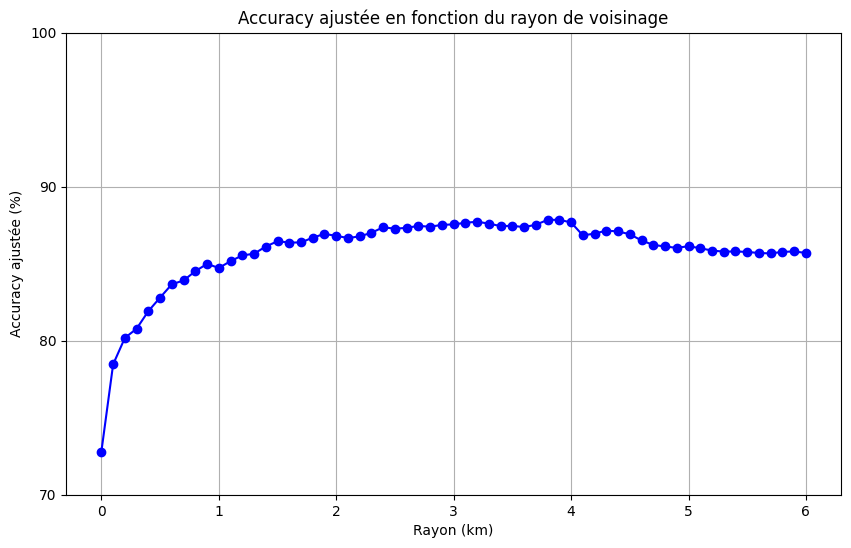

[72.80030717429187,
 78.46530998021089,
 80.18135097616445,
 80.78093156511208,
 81.92102076380068,
 82.80119325397997,
 83.66659774935759,
 83.91174646306524,
 84.5142806509732,
 84.98981008358685,
 84.72398617715686,
 85.16702602120684,
 85.53917949020882,
 85.64846265174114,
 86.11513128747379,
 86.46070236583276,
 86.3750479959831,
 86.38095519390377,
 86.69403668369908,
 86.9362317984464,
 86.80922704315208,
 86.67040789201643,
 86.77378385562808,
 87.01007177245474,
 87.36745724665505,
 87.27294207992439,
 87.33201405913104,
 87.45606521546505,
 87.40290043417905,
 87.5239979915527,
 87.55353398115604,
 87.65986354372804,
 87.7277963198157,
 87.6037451634817,
 87.44425081962372,
 87.46197241338571,
 87.37631804353605,
 87.53285878843371,
 87.84594027822902,
 87.85184747614969,
 87.68053873645036,
 86.84171663171576,
 86.9539533922084,
 87.15184452255073,
 87.0957261423044,
 86.91555660572408,
 86.51091354815843,
 86.22146085004579,
 86.12103848539445,
 86.02947691762412,
 86.1387

In [126]:
# Récupération des paramètres estimés
beta_estimates = results['binary_logit_seats'].get_beta_values()

V_seats_10_test = (
    beta_estimates['ASC_1'] + beta_estimates['beta_price'] * test_data['unit_price'] +
    beta_estimates['beta_tramstopdist'] * test_data['tram_stop_distance'] +
    beta_estimates['beta_busstopdist'] * test_data['bus_stop_distance'] +
    beta_estimates['beta_busstopdens'] * test_data['bus_stop_density'] +
    beta_estimates['beta_bikerentdist'] * test_data['bicycle_rental_distance'] +
    beta_estimates['beta_densPop_2'] * test_data['pop_dens_b'] +
    beta_estimates['beta_densPop_3'] * test_data['pop_dens_c'] +
    beta_estimates['beta_densPop_4'] * test_data['pop_dens_d'] +
    beta_estimates['beta_densPop_5'] * test_data['pop_dens_e'] +
    beta_estimates['beta_departure_2'] * test_data['time_Morning_Normal'] +
    beta_estimates['beta_departure_3'] * test_data['time_Morning_Pick'] +
    beta_estimates['beta_departure_4'] * test_data['time_Mid_day'] +
    beta_estimates['beta_departure_5'] * test_data['time_Evening_Pick'] +
    beta_estimates['beta_departure_6'] * test_data['time_Evening_Normal'] +
    beta_estimates['beta_banlieue'] * test_data['Banlieue'] 
    
)

# Utilité pour l'alternative 0 (baseline) est toujours 0
V_10_test = np.zeros_like(V_seats_10_test)

# Calcul des probabilités pour chaque observation dans les données de test
probabilities_test = np.exp(V_seats_10_test) / (np.exp(V_seats_10_test) + np.exp(V_10_test))

# Affichage des probabilités simulées
print(probabilities_test)

# Calcul des prédictions : Si la probabilité pour l'alternative 1 est plus grande que 0.5, on prédit l'alternative 1, sinon on prédit l'alternative 0
predictions = (probabilities_test > 0.5).astype(int)
print(predictions)

# Comparer avec l'alternative réellement choisie (assumant qu'elle soit dans la colonne 'ChosenAlternative')
correct_predictions = (predictions == test_data['binary_seats']).sum()

# Calcul du pourcentage de prédictions correctes
accuracy = (correct_predictions / len(test_data)) * 100

# Affichage du pourcentage de prédictions correctes
print(f"Pourcentage de prédictions correctes : {accuracy:.2f}%")

adjusted_accuracy(test_data, predictions,6)
